In [1]:
# ============================================================
# BLOCK 0A: Choose GPU + reduce fragmentation
# IMPORTANT: restart kernel after running this cell.
# ============================================================
import os

# Pick a free GPU: "1" or "2" (your nvidia-smi shows these are empty)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Helps fragmentation in shared environments
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

### Environment Setup and Experiment Configuration

This block initializes the experimental environment used throughout the Seq2Seq music transcription notebook. It consolidates all library imports, filesystem paths, device configuration, and reproducibility settings in a single place to ensure consistency across runs.

The dataset paths correspond to a pre-extracted *MusicNet* subset, with separate directories for audio files and symbolic labels in both training and test splits. All derived artifacts—feature files, checkpoints, figures, vocabulary metadata, and dataset manifests—are written to a shared output directory, allowing the notebook to be rerun without overwriting raw data.

Device selection is handled dynamically, enabling GPU acceleration when available while remaining compatible with CPU-only environments. CUDA benchmarking is enabled to optimize convolution performance for fixed input sizes, which is particularly relevant for CNN-based acoustic encoders.

Finally, a global random seed is set across Python, NumPy, and PyTorch to ensure reproducibility of data loading, model initialization, and training behavior. Sanity checks confirm the existence of all required dataset paths before proceeding.


In [ ]:
# ============================================================
# BLOCK 0B: Imports + Paths + Device
# ============================================================

from __future__ import annotations
import os, json, time, math, random
from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from collections import Counter, defaultdict

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import librosa
import matplotlib.pyplot as plt

# -----------------------------
# Your paths (adjust accordingly)
# -----------------------------
WORK_DIR = Path("/home/jovyan/work")
SMALL_ROOT = WORK_DIR / "musicnet_small/musicnet_small"

TRAIN_AUDIO_DIR = SMALL_ROOT / "train_data"
TRAIN_LABEL_DIR = SMALL_ROOT / "train_labels"
TEST_AUDIO_DIR  = SMALL_ROOT / "test_data"
TEST_LABEL_DIR  = SMALL_ROOT / "test_labels"
META_PATH = WORK_DIR / "musicnet_metadata.csv"

# Outputs
OUT_ROOT = Path("/home/jovyan/shared/musicnet_event_notebook")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

FEAT_DIR = OUT_ROOT / "mel_event_npz"
FEAT_DIR.mkdir(parents=True, exist_ok=True)

CKPT_DIR = OUT_ROOT / "checkpoints"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

FIG_DIR = OUT_ROOT / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

MANIFEST_PATH = OUT_ROOT / "manifest.csv"
SPLITS_PATH   = OUT_ROOT / "splits.json"
VOCAB_PATH    = OUT_ROOT / "vocab_info.json"

# -----------------------------
# Device
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)
if DEVICE == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True

# Stable loaders on JupyterHub
NUM_WORKERS = 0
PIN_MEMORY = (DEVICE == "cuda")

# Repro
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Sanity
assert TRAIN_AUDIO_DIR.exists() and TRAIN_LABEL_DIR.exists()
assert TEST_AUDIO_DIR.exists() and TEST_LABEL_DIR.exists()
assert META_PATH.exists()

print("OUT_ROOT:", OUT_ROOT)

DEVICE: cuda
GPU: Tesla V100-PCIE-16GB
OUT_ROOT: /home/jovyan/shared/musicnet_event_notebook


### Dataset Indexing and Train/Validation/Test Split Construction

This block enumerates the available audio files in the pre-defined *MusicNet* subset and constructs stable integer track IDs from the `.wav` filenames. These IDs become the canonical identifiers used throughout the notebook to link audio, label files, extracted features, and evaluation outputs.

Metadata is loaded from `musicnet_metadata.csv` and aligned to the discovered training pool IDs. A small validation set (`N_VAL = 8`) is created from the training pool while keeping the official test split fixed (`TEST_IDS`). The key design choice is that the validation split is **group-aware**: tracks are grouped by `(composer, composition)` so that the validation set preferentially contains entire musical works rather than random isolated tracks. This reduces leakage where near-identical pieces (same work, different recording/segment) could otherwise appear in both train and validation and artificially inflate validation performance.

The split generation is deterministic via a fixed random seed, ensuring that model comparisons (e.g., Seq2Seq vs. CTC) are evaluated on the same data partition across runs. The resulting split dictionary is persisted to disk (`splits.json`) so later notebook stages can reload consistent IDs without recomputing the split.


In [5]:
def list_wavs(d: Path): return sorted(d.glob("*.wav"))
train_wavs = list_wavs(TRAIN_AUDIO_DIR)
test_wavs  = list_wavs(TEST_AUDIO_DIR)

TRAIN_POOL_IDS = sorted([int(p.stem) for p in train_wavs])
TEST_IDS       = sorted([int(p.stem) for p in test_wavs])

meta = pd.read_csv(META_PATH)
meta["id"] = meta["id"].astype(int)

N_VAL = 8
assert len(TRAIN_POOL_IDS) >= 40 and len(TEST_IDS) == 10

def work_key(row: pd.Series) -> Tuple[str,str]:
    return (str(row.get("composer","UNKNOWN")).strip(), str(row.get("composition","UNKNOWN")).strip())

def make_val_split(meta_df, train_pool_ids, n_val=8, seed=42):
    rng = random.Random(seed)
    df = meta_df[meta_df["id"].isin(train_pool_ids)].copy()
    df["composer"] = df["composer"].fillna("UNKNOWN_COMPOSER")
    df["composition"] = df["composition"].fillna(df["id"].apply(lambda x: f"id_{x}"))
    df["work_key"] = df.apply(work_key, axis=1)
    groups = df.groupby("work_key")["id"].apply(list).tolist()
    rng.shuffle(groups)
    val_ids = []
    for g in groups:
        if len(val_ids) + len(g) <= n_val:
            val_ids.extend(g)
        if len(val_ids) == n_val:
            break
    if len(val_ids) < n_val:
        remaining = [tid for tid in train_pool_ids if tid not in val_ids]
        rng.shuffle(remaining)
        val_ids.extend(remaining[:(n_val - len(val_ids))])
    val_ids = sorted(set(val_ids))
    train_ids = sorted([tid for tid in train_pool_ids if tid not in val_ids])
    return train_ids, val_ids

train_ids, val_ids = make_val_split(meta, TRAIN_POOL_IDS, n_val=N_VAL, seed=42)
splits = {"train_ids": train_ids, "val_ids": val_ids, "test_ids": TEST_IDS}
with open(SPLITS_PATH, "w") as f:
    json.dump(splits, f, indent=2)

print("Saved:", SPLITS_PATH)
print("Train/Val/Test:", len(train_ids), len(val_ids), len(TEST_IDS))
print("Val IDs:", val_ids)


Saved: /home/jovyan/shared/musicnet_event_notebook/splits.json
Train/Val/Test: 32 8 10
Val IDs: [2200, 2201, 2213, 2214, 2215, 2224, 2591, 2620]


### Symbolic Label Loading and Pitch Normalization

This block defines the interface for reading symbolic annotation files and mapping raw MIDI note numbers into a normalized pitch index space suitable for modeling.

Each label file is expected to contain note-level events with explicit onset and offset times, instrument identifiers, and MIDI note values. The loader enforces the presence of these fields and casts all values to integer types to ensure consistent downstream processing and tensor conversion.

Pitch values are constrained to the standard 88-key piano range (MIDI notes 21–108), which aligns with the MusicNet annotation conventions and the typical scope of polyphonic piano transcription. Notes outside this range are treated as invalid and mapped to a sentinel value.

By converting MIDI notes into zero-based pitch indices, this block establishes a compact and contiguous pitch representation that can be cleanly embedded into event vocabularies or frame-based targets in later stages of the pipeline.


In [6]:
def read_label_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    required = {"start_time","end_time","instrument","note"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"{path} missing columns: {missing}")
    df = df.copy()
    df["start_time"] = df["start_time"].astype(int)
    df["end_time"]   = df["end_time"].astype(int)
    df["instrument"] = df["instrument"].astype(int)
    df["note"]       = df["note"].astype(int)
    return df

MIN_NOTE = 21
MAX_NOTE = 108
N_PITCH  = MAX_NOTE - MIN_NOTE + 1  # 88

def note_to_pitch_id(note: int) -> int:
    if note < MIN_NOTE or note > MAX_NOTE:
        return -1
    return note - MIN_NOTE


### Event-Based Vocabulary Definition for Seq2Seq Decoding

This block defines the discrete event vocabulary used by the Seq2Seq decoder to represent polyphonic music as a sequence of symbolic tokens. Instead of predicting frame-wise pitch activations, the model operates on an **event-based representation** that explicitly encodes temporal progression and note state changes.

Time is represented through *time-shift tokens*, which advance the internal clock by a fixed number of discrete steps. The maximum allowed shift (`MAX_SHIFT`) limits the longest silence or sustained interval that can be expressed by a single token. Musical content is represented using separate *note-on* and *note-off* events, indexed over the normalized pitch range.

All event types are assigned non-overlapping index ranges within a single contiguous vocabulary. Special symbols are appended after the event vocabulary to support sequence modeling: padding for batch alignment, start-of-sequence and end-of-sequence markers for autoregressive decoding, and a dedicated blank symbol for CTC-based baselines.

Utility functions map semantic events (time shift, note on, note off) to their corresponding token IDs, ensuring a consistent encoding scheme across preprocessing, training, and evaluation. The full vocabulary specification is serialized to disk so that decoding and evaluation remain aligned with the exact token layout used during training.


In [7]:
MAX_SHIFT = 100

TIME_SHIFT_BASE = 0
NOTE_ON_BASE    = TIME_SHIFT_BASE + MAX_SHIFT
NOTE_OFF_BASE   = NOTE_ON_BASE + N_PITCH
EVENT_VOCAB     = NOTE_OFF_BASE + N_PITCH

PAD_ID = EVENT_VOCAB
SOS_ID = EVENT_VOCAB + 1
EOS_ID = EVENT_VOCAB + 2
CTC_BLANK_ID = EVENT_VOCAB + 3
TOTAL_VOCAB = EVENT_VOCAB + 4

def tok_time_shift(k: int) -> int: return TIME_SHIFT_BASE + (k - 1)
def tok_note_on(p: int) -> int: return NOTE_ON_BASE + p
def tok_note_off(p: int) -> int: return NOTE_OFF_BASE + p

with open(VOCAB_PATH, "w") as f:
    json.dump(dict(MAX_SHIFT=MAX_SHIFT, N_PITCH=N_PITCH, EVENT_VOCAB=EVENT_VOCAB,
                   PAD_ID=PAD_ID, SOS_ID=SOS_ID, EOS_ID=EOS_ID, CTC_BLANK_ID=CTC_BLANK_ID,
                   TOTAL_VOCAB=TOTAL_VOCAB,
                   TIME_SHIFT_BASE=TIME_SHIFT_BASE, NOTE_ON_BASE=NOTE_ON_BASE, NOTE_OFF_BASE=NOTE_OFF_BASE),
              f, indent=2)

print("Vocab saved:", VOCAB_PATH, "| TOTAL_VOCAB:", TOTAL_VOCAB)


Vocab saved: /home/jovyan/shared/musicnet_event_notebook/vocab_info.json | TOTAL_VOCAB: 280


### Audio Feature Configuration and Event-Token Target Generation

This block defines the preprocessing configuration for the acoustic input representation and implements the conversion from note-level labels into an **event-token sequence** aligned to short audio segments.

A dedicated configuration dataclass (`PreprocCfg`) centralizes all signal-processing hyperparameters, including sampling rate, STFT settings, mel filterbank resolution, frequency bounds, and the segmenting scheme (segment length and hop between segments). Keeping these parameters explicit and versioned is essential because they determine the time resolution of both the encoder input and the target tokenization.

`compute_logmel(...)` converts raw waveform audio into a log-mel spectrogram. Log compression stabilizes dynamic range, and optional normalization standardizes feature scaling across examples, improving training stability for CNN/RNN-based acoustic encoders.

`events_for_segment(...)` constructs the Seq2Seq target sequence for a given segment by:
- selecting all note events whose active interval overlaps the segment window,
- mapping note onsets/offsets from sample indices to **frame indices** using the same `hop_length` as the spectrogram,
- emitting a sequence of **time-shift tokens** to advance the event timeline between frames,
- emitting **note-off tokens before note-on tokens** at the same frame to enforce a consistent ordering and reduce ambiguity,
- appending an explicit `EOS` token to mark sequence termination for autoregressive decoding.

The `MAX_SHIFT` constraint ensures long temporal gaps are represented as multiple time-shift tokens rather than a single unbounded jump, which keeps the vocabulary fixed and the decoding problem well-conditioned.


In [8]:
@dataclass
class PreprocCfg:
    sr: int = 44100
    n_fft: int = 2048
    hop_length: int = 512
    n_mels: int = 128
    fmin: float = 30.0
    fmax: float = 8000.0
    seg_seconds: float = 10.0
    hop_seconds: float = 5.0
    log_eps: float = 1e-6
    normalize: bool = True

CFG = PreprocCfg()
print("CFG:", CFG)

def compute_logmel(y: np.ndarray, cfg: PreprocCfg) -> np.ndarray:
    S = librosa.feature.melspectrogram(
        y=y, sr=cfg.sr, n_fft=cfg.n_fft, hop_length=cfg.hop_length,
        n_mels=cfg.n_mels, fmin=cfg.fmin, fmax=cfg.fmax,
        power=2.0, center=False
    )
    X = np.log(S.astype(np.float32) + cfg.log_eps)
    if cfg.normalize:
        X = (X - X.mean()) / (X.std() + 1e-8)
    return X.astype(np.float32)  # (M,T)

def events_for_segment(df: pd.DataFrame, seg_start_samp: int, seg_end_samp: int, cfg: PreprocCfg) -> List[int]:
    d = df[(df["start_time"] < seg_end_samp) & (df["end_time"] > seg_start_samp)].copy()
    if len(d) == 0:
        return []

    def samp_to_frame(s): return int((s - seg_start_samp) // cfg.hop_length)

    on_map  = defaultdict(list)
    off_map = defaultdict(list)

    for _, r in d.iterrows():
        p = note_to_pitch_id(int(r["note"]))
        if p < 0: 
            continue
        on_f  = max(0, samp_to_frame(int(r["start_time"])))
        off_f = max(0, samp_to_frame(int(r["end_time"])))
        on_map[on_f].append(p)
        off_map[off_f].append(p)

    frames = sorted(set(on_map.keys()) | set(off_map.keys()))
    if not frames:
        return []

    toks = []
    cur = 0
    for f in frames:
        dt = f - cur
        while dt > 0:
            k = min(MAX_SHIFT, dt)
            toks.append(tok_time_shift(k))
            dt -= k
        cur = f

        for p in sorted(off_map.get(f, [])):
            toks.append(tok_note_off(p))
        for p in sorted(on_map.get(f, [])):
            toks.append(tok_note_on(p))

    toks.append(EOS_ID)
    return toks


CFG: PreprocCfg(sr=44100, n_fft=2048, hop_length=512, n_mels=128, fmin=30.0, fmax=8000.0, seg_seconds=10.0, hop_seconds=5.0, log_eps=1e-06, normalize=True)


### Segment-Level Feature/Target Precomputation and Manifest Creation

This block converts the raw MusicNet subset into a segment-based training corpus by precomputing paired inputs and targets and storing them as compressed `.npz` files. The goal is to decouple expensive audio preprocessing from model training so that subsequent epochs load features efficiently and deterministically.

Audio is divided into overlapping fixed-length segments (`seg_seconds`) with a fixed hop (`hop_seconds`). Each segment is processed into:
- an acoustic input matrix `X` (log-mel spectrogram, transposed to time-major shape `(T, M)`), and
- an event-token target sequence `y` generated from the label intervals restricted to that segment window.

Segments that contain no overlapping labeled note activity are skipped to avoid training on empty targets. For each retained segment, the notebook writes a compressed `.npz` containing:
- `X`: time-major log-mel features (stored as `float16` to reduce storage and I/O),
- `y`: the event-token sequence (`int32`),
- `meta`: a JSON string capturing traceable segment metadata (track ID, split, sample indices, hop length, etc.).

A manifest table is constructed alongside this process. The manifest is the canonical index used later by the Dataset/DataLoader: it records each segment’s split assignment, path to its `.npz`, and basic statistics such as number of frames and number of tokens. If a manifest already exists, it is reused to ensure stable training runs; rebuilding is only triggered when preprocessing logic changes (e.g., vocabulary/tokenizer adjustments) via `FORCE_REBUILD`.

Finally, the manifest is cleaned against missing files and summary diagnostics are printed, including split counts and upper-quantile token lengths. These statistics are used downstream to choose padding/max-length limits and to anticipate memory usage during batching.


In [9]:
FORCE_REBUILD = False  # set True if you changed vocab/tokenizer and must rebuild

seg_len_samp = int(CFG.seg_seconds * CFG.sr)
hop_len_samp = int(CFG.hop_seconds * CFG.sr)

def build_index_df():
    rows = []
    for w in sorted(TRAIN_AUDIO_DIR.glob("*.wav")):
        tid = int(w.stem)
        rows.append({"id": tid, "audio": str(w), "label": str(TRAIN_LABEL_DIR / f"{tid}.csv")})
    for w in sorted(TEST_AUDIO_DIR.glob("*.wav")):
        tid = int(w.stem)
        rows.append({"id": tid, "audio": str(w), "label": str(TEST_LABEL_DIR / f"{tid}.csv")})
    return pd.DataFrame(rows)

index_df = build_index_df()
with open(SPLITS_PATH, "r") as f:
    splits = json.load(f)

id_to_split = {int(t): "train" for t in splits["train_ids"]}
id_to_split.update({int(t): "val" for t in splits["val_ids"]})
id_to_split.update({int(t): "test" for t in splits["test_ids"]})

if FORCE_REBUILD:
    print("Rebuilding features: wiping FEAT_DIR ...")
    for p in FEAT_DIR.glob("*.npz"):
        p.unlink(missing_ok=True)

if MANIFEST_PATH.exists() and not FORCE_REBUILD:
    manifest = pd.read_csv(MANIFEST_PATH)
    print("Loaded manifest:", MANIFEST_PATH)
else:
    rows = []
    print("Precomputing NPZ ...", flush=True)
    for _, r in index_df[index_df["id"].isin(id_to_split.keys())].iterrows():
        tid = int(r["id"])
        split = id_to_split[tid]
        wav_path = Path(r["audio"])
        lab_path = Path(r["label"])

        y_audio, _ = librosa.load(wav_path, sr=CFG.sr, mono=True)
        labs = read_label_csv(lab_path)
        total_samp = len(y_audio)
        seg_i = 0

        for seg_start in range(0, max(1, total_samp - seg_len_samp + 1), hop_len_samp):
            seg_end = seg_start + seg_len_samp
            if seg_end > total_samp:
                break

            X_mel = compute_logmel(y_audio[seg_start:seg_end], CFG)  # (M,T)
            X = X_mel.T  # (T,M)

            y_tok = events_for_segment(labs, seg_start, seg_end, CFG)
            if len(y_tok) == 0:
                continue

            npz_path = FEAT_DIR / f"{split}_id{tid}_seg{seg_i:05d}.npz"
            meta_out = dict(track_id=tid, split=split,
                            seg_start_samp=int(seg_start), seg_end_samp=int(seg_end),
                            hop_length=CFG.hop_length, sr=CFG.sr, n_mels=CFG.n_mels)

            np.savez_compressed(npz_path, X=X.astype(np.float16), y=np.asarray(y_tok, np.int32), meta=json.dumps(meta_out))

            rows.append(dict(split=split, track_id=tid, seg_idx=seg_i,
                             npz_path=str(npz_path), n_frames=int(X.shape[0]), n_tokens=int(len(y_tok))))
            seg_i += 1

    manifest = pd.DataFrame(rows)
    manifest.to_csv(MANIFEST_PATH, index=False)
    print("Saved manifest:", MANIFEST_PATH)

# Clean manifest (remove missing)
exists_mask = manifest["npz_path"].apply(lambda p: os.path.exists(p))
manifest = manifest.loc[exists_mask].reset_index(drop=True)
manifest.to_csv(MANIFEST_PATH, index=False)

print(manifest["split"].value_counts())
print("train token p90/p95:",
      manifest[manifest["split"]=="train"]["n_tokens"].quantile(0.9),
      manifest[manifest["split"]=="train"]["n_tokens"].quantile(0.95))


Loaded manifest: /home/jovyan/shared/musicnet_event_notebook/manifest.csv
split
train    693
test     280
val      194
Name: count, dtype: int64
train token p90/p95: 524.6000000000001 599.0


### Dataset and DataLoader Construction (Segment-Level Batching)

This block instantiates the PyTorch dataset and dataloaders used for Seq2Seq training, validation, and testing based on the previously generated segment manifest.

The manifest is split into `train_df`, `val_df`, and `test_df` by split label. A maximum token-length constraint (`MAX_TOKENS_TRAIN`) is applied to the training set to remove unusually long target sequences. This acts as a practical guardrail for GPU memory, batch padding overhead, and training stability, since autoregressive decoders scale with target length and extreme outliers can dominate runtime.

`SegmentDataset` is a lightweight wrapper around the manifest rows. Each example loads a precomputed `.npz` file and returns:
- `X`: time-major log-mel features `(T, M)`,
- `y`: event-token targets `(L,)`,
- `x_len` and `y_len`: the unpadded lengths for masking and loss computation,
- `meta`: segment metadata for traceability (track ID, segment bounds, split, etc.).

A custom `collate(...)` function performs dynamic padding within each batch:
- acoustic features are padded with zeros to `(B, T_max, M)`,
- token sequences are padded with `PAD_ID` to `(B, L_max)`,
- length tensors are retained to enable correct masking in attention and to prevent loss contributions from padded positions.

Batch size is set conditionally based on GPU availability, and the final sanity check prints the shapes of one sampled batch to confirm that the pipeline produces correctly padded tensors.


In [10]:
manifest = pd.read_csv(MANIFEST_PATH)
train_df = manifest[manifest["split"]=="train"].reset_index(drop=True)
val_df   = manifest[manifest["split"]=="val"].reset_index(drop=True)
test_df  = manifest[manifest["split"]=="test"].reset_index(drop=True)

MAX_TOKENS_TRAIN = 500
train_df = train_df[train_df["n_tokens"] <= MAX_TOKENS_TRAIN].reset_index(drop=True)

print("Segments train/val/test:", len(train_df), len(val_df), len(test_df))

class SegmentDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        z = np.load(row["npz_path"], allow_pickle=False)
        X = torch.from_numpy(z["X"].astype(np.float32))  # (T,M)
        y = torch.from_numpy(z["y"].astype(np.int64))    # (L,)
        meta = json.loads(z["meta"].item())
        return {"X": X, "x_len": X.shape[0], "y": y, "y_len": y.shape[0], "meta": meta}

def collate(batch):
    B = len(batch)
    Tm = max(b["x_len"] for b in batch)
    Lm = max(b["y_len"] for b in batch)
    M  = batch[0]["X"].shape[1]
    X_pad = torch.zeros((B,Tm,M), dtype=torch.float32)
    x_lens = torch.tensor([b["x_len"] for b in batch], dtype=torch.long)
    y_pad = torch.full((B,Lm), PAD_ID, dtype=torch.long)
    y_lens = torch.tensor([b["y_len"] for b in batch], dtype=torch.long)
    metas=[]
    for i,b in enumerate(batch):
        X_pad[i,:b["x_len"]] = b["X"]
        y_pad[i,:b["y_len"]] = b["y"]
        metas.append(b["meta"])
    return {"X": X_pad, "x_lens": x_lens, "y": y_pad, "y_lens": y_lens, "meta": metas}

BATCH = 8 if DEVICE=="cuda" else 4
train_loader = DataLoader(SegmentDataset(train_df), batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=PIN_MEMORY, collate_fn=collate)
val_loader   = DataLoader(SegmentDataset(val_df),   batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY, collate_fn=collate)
test_loader  = DataLoader(SegmentDataset(test_df),  batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY, collate_fn=collate)

b = next(iter(train_loader))
print("Batch X:", b["X"].shape, "Batch y:", b["y"].shape)


Segments train/val/test: 614 194 280
Batch X: torch.Size([8, 858, 128]) Batch y: torch.Size([8, 449])


### Acoustic Encoder: CNN Front-End + BiLSTM Temporal Context

This block defines the shared acoustic encoder used to transform log-mel spectrogram segments into a sequence of latent representations suitable for attention-based decoding (and reusable for CTC baselines).

**Input/Output contract**
- Input: `X` with shape `(B, T, M)` where `T` is the number of time frames and `M` is the number of mel bins.
- Output: `enc` with shape `(B, T', 2 * lstm_hidden)` representing bidirectional contextual embeddings per time step, plus the corresponding sequence lengths.

**CNN front-end (time-preserving, frequency-downsampling)**
The encoder first applies a 2D CNN stack over `(time × frequency)` with `Conv2d → BatchNorm → ReLU`. Each stage uses `MaxPool2d((1,2))`, which **only downsamples the mel/frequency axis** while keeping the time resolution unchanged. After three pooling stages, the frequency dimension is reduced by a factor of `2^3 = 8`, yielding `mel_after = n_mels // 8`.

The CNN output is then rearranged and flattened into a time-major sequence:
- `(B, C, T, F') → (B, T, C·F')`,
so each time step is represented by a learned feature vector that summarizes local time–frequency patterns.

**BiLSTM sequence model (long-range temporal context)**
The flattened per-frame features are passed into a multi-layer bidirectional LSTM. This stage models musical context over time (e.g., sustained notes, repeated motifs, co-occurrences), producing encoder states that incorporate both past and future information at each frame. The bidirectional setting doubles the hidden size in the output (`2 * lstm_hidden`).

**Length-aware computation**
Variable-length segments are handled using `pack_padded_sequence` and `pad_packed_sequence`, ensuring the LSTM does not waste computation on padded frames and enabling correct masking later in attention.

Overall, the encoder produces a dense sequence of contextual embeddings that the decoder can attend to when generating event tokens.


In [11]:
class CNNBiLSTMEncoder(nn.Module):
    def __init__(self, n_mels: int, cnn_ch=(32,64,128), lstm_hidden=256, lstm_layers=2, drop=0.2):
        super().__init__()
        c1,c2,c3 = cnn_ch
        self.cnn = nn.Sequential(
            nn.Conv2d(1,c1,3,padding=1), nn.BatchNorm2d(c1), nn.ReLU(), nn.MaxPool2d((1,2)),
            nn.Conv2d(c1,c2,3,padding=1), nn.BatchNorm2d(c2), nn.ReLU(), nn.MaxPool2d((1,2)),
            nn.Conv2d(c2,c3,3,padding=1), nn.BatchNorm2d(c3), nn.ReLU(), nn.MaxPool2d((1,2)),
        )
        mel_after = n_mels // 8
        self.proj_in = c3 * mel_after
        self.lstm = nn.LSTM(self.proj_in, lstm_hidden, num_layers=lstm_layers,
                            batch_first=True, bidirectional=True,
                            dropout=drop if lstm_layers>1 else 0.0)

    def forward(self, X, x_lens):
        B,T,M = X.shape
        x = X.unsqueeze(1)
        x = self.cnn(x)
        x = x.permute(0,2,1,3).contiguous()
        x = x.view(B, x.size(1), -1)
        packed = nn.utils.rnn.pack_padded_sequence(x, x_lens.cpu(), batch_first=True, enforce_sorted=False)
        enc,_ = self.lstm(packed)
        enc,_ = nn.utils.rnn.pad_packed_sequence(enc, batch_first=True)
        return enc, x_lens


### Token-Level Edit Distance Metric (Levenshtein Distance)

This utility implements the standard Levenshtein edit distance between two token sequences. It measures the minimum number of insertions, deletions, and substitutions required to transform a predicted event sequence into the reference sequence.

In the context of event-based music transcription, this metric is used to quantify **sequence-level accuracy** rather than frame-level overlap. Unlike pitch-wise F1 scores, edit distance directly reflects structural errors in the decoded event stream, such as missing note-on events, spurious note-offs, or incorrect temporal ordering.

The implementation uses a dynamic programming formulation with linear memory in the length of the reference sequence, making it efficient enough to compute repeatedly during validation. Edit distance values are later normalized by target length to form **Token Error Rate (TER)**, which serves as a primary evaluation metric for comparing Seq2Seq decoding performance across models and training checkpoints.


In [12]:
def edit_distance(a: List[int], b: List[int]) -> int:
    n,m=len(a),len(b)
    dp=list(range(m+1))
    for i in range(1,n+1):
        prev=dp[0]; dp[0]=i
        for j in range(1,m+1):
            cur=dp[j]
            cost=0 if a[i-1]==b[j-1] else 1
            dp[j]=min(dp[j]+1, dp[j-1]+1, prev+cost)
            prev=cur
    return dp[m]


### Fast Seq2Seq Training (Attention-RNN) with Scheduled Sampling and Subset Validation

This block defines and trains the event-based Seq2Seq model used for polyphonic music transcription. It is optimized for **fast feedback**: each epoch prints a single summary line using (i) full training loss and (ii) **quick validation on a small subset with short greedy decoding**. A separate block performs full/slow decoding sweeps.

---

#### Token-class reweighting (addressing vocabulary imbalance)

Event-token frequencies are strongly skewed (time-shifts occur far more often than note events). `CLASS_W` applies higher loss weight to underrepresented regions of the vocabulary:
- time-shifts are upweighted to discourage trivial “always shift” behavior,
- note-on/note-off are moderately upweighted to improve musical event detection,
- EOS is upweighted to stabilize sequence termination.

Special symbols (`PAD`, `SOS`, and optionally `CTC_BLANK`) are assigned zero weight so they do not contribute to the optimization objective.

---

#### Additive attention (AMP-safe implementation)

`AdditiveAttention` implements Bahdanau-style additive attention:
- projects decoder state `h_t` and encoder states `enc` into a shared attention space,
- computes per-time-step energies and applies a padding mask (`enc_mask`) before softmax,
- forms a context vector `ctx` as the weighted sum of encoder states.

Attention computations are carried out in float32 for numerical stability under mixed precision, then cast back to the encoder dtype so the rest of the forward pass remains AMP-compatible.

---

#### Seq2Seq architecture: encoder + embedding + LSTM decoder + attention + output head

`S2SAttn` couples:
- the `CNNBiLSTMEncoder` (producing contextual encoder states),
- an embedding layer for event tokens,
- a multi-layer LSTM decoder that consumes `[token_embedding ; context_vector]` each step,
- a linear classifier producing logits over `TOTAL_VOCAB`.

The encoder mask is computed from `x_lens` so attention cannot attend to padded frames.

Two forward modes are provided:
- `forward_teacher_forcing(...)`: consumes the full teacher-forced input sequence and returns logits at every step (used for loss and validation loss).
- `forward_scheduled(...)`: autoregressive training with **scheduled sampling**, mixing ground-truth inputs with model-predicted inputs.

---

#### Seq2Seq I/O formatting (SOS/EOS alignment)

`make_s2s_io_event(...)` transforms the padded target `y` (which already contains EOS in the dataset) into:
- `y_in  = [SOS] + y[:-1]`
- `y_out = y`

This creates the standard next-token prediction setup while preserving padding with `PAD_ID` so the loss can ignore padded positions.

---

#### Fast greedy decoding for training-time validation

`s2s_decode_fast(...)` performs constrained greedy decoding for speed:
- starts from `SOS`,
- suppresses invalid tokens during decoding (`PAD`, `SOS`, `CTC_BLANK`),
- prevents emitting `EOS` before `min_len` steps to avoid early-epoch collapse,
- stops once all sequences emit EOS or `max_len` is reached.

This decoder is deliberately minimal and is used only to compute quick, coarse validation metrics per epoch.

---

#### Fast validation metrics (subset only)

`fast_val_metrics(...)` evaluates only the first `max_batches` from `val_loader`:
- `loss`: teacher-forced weighted cross entropy (PAD ignored),
- `TER`: token error rate computed as edit distance normalized by target length,
- `P/R/F1`: micro-averaged token F1 using `Counter` overlap between predicted and target multisets,
- `pred_len_mean` vs. `tgt_len_mean`: length diagnostics to detect under-generation or runaway decoding.

These metrics are intended for trend monitoring and early stopping decisions, not final reporting.

---

#### Training loop: AMP + grad accumulation + clipping + early stopping

`train_s2s_scheduled_fast(...)` trains the model with:
- AdamW optimization and weight decay,
- mixed precision scaling (`GradScaler`) when running on CUDA,
- gradient accumulation (`grad_accum_steps`) to increase effective batch size under memory constraints,
- gradient clipping to stabilize RNN optimization,
- scheduled sampling probability ramp: `ss_prob = min(0.2, 0.02 * (epoch-1))`,
- early stopping on the subset validation loss,
- checkpointing the best model to `CKPT_DIR / "best_s2s_event_sched.pt"`.

---

#### Execution: instantiate encoder + Seq2Seq model and train

The block instantiates `CNNBiLSTMEncoder` using the configured mel dimension and builds the `S2SAttn` model with `TOTAL_VOCAB`. Training is launched with the fast-loop settings, and the best checkpoint path is returned for use in later evaluation blocks.


In [13]:
# ============================================================
# BLOCK 10 (FAST TRAIN): Seq2Seq (Attention-RNN) + Scheduled Sampling
# Prints ONE line per epoch quickly (train + FAST val subset)
#
# IMPORTANT: This block intentionally does NOT do full-val decoding per epoch.
# Full/slow decode sweep is in Block 10b.
#
# REQUIRES already defined earlier:
# - DEVICE, CFG, N_PITCH
# - vocab constants: TIME_SHIFT_BASE, NOTE_ON_BASE, NOTE_OFF_BASE, EVENT_VOCAB,
#   PAD_ID, SOS_ID, EOS_ID, CTC_BLANK_ID, TOTAL_VOCAB
# - CNNBiLSTMEncoder class
# - train_loader, val_loader
# - edit_distance function
# ============================================================

import time
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# CLASS WEIGHTS (fix distribution)
# -----------------------------
CLASS_W = torch.ones(TOTAL_VOCAB, dtype=torch.float32, device=DEVICE)
CLASS_W[TIME_SHIFT_BASE:NOTE_ON_BASE] = 4.0
CLASS_W[NOTE_ON_BASE:NOTE_OFF_BASE]   = 1.3
CLASS_W[NOTE_OFF_BASE:EVENT_VOCAB]    = 1.2
CLASS_W[EOS_ID] = 3.0
CLASS_W[PAD_ID] = 0.0
CLASS_W[SOS_ID] = 0.0
if CTC_BLANK_ID < TOTAL_VOCAB:
    CLASS_W[CTC_BLANK_ID] = 0.0

print("CLASS_W:", float(CLASS_W[TIME_SHIFT_BASE]), float(CLASS_W[NOTE_ON_BASE]), float(CLASS_W[NOTE_OFF_BASE]), float(CLASS_W[EOS_ID]))

# -----------------------------
# AMP-safe Additive Attention
# -----------------------------
class AdditiveAttention(nn.Module):
    def __init__(self, dec_dim: int, enc_dim: int, attn_dim: int = 256):
        super().__init__()
        self.W_h = nn.Linear(dec_dim, attn_dim, bias=False)
        self.W_s = nn.Linear(enc_dim, attn_dim, bias=False)
        self.v   = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, h_t, enc, enc_mask):
        h32 = h_t.float()
        e32 = enc.float()
        energy = self.v(torch.tanh(self.W_h(h32).unsqueeze(1) + self.W_s(e32))).squeeze(-1)  # (B,Tx)
        energy = energy.masked_fill(enc_mask, -1e4)
        attn = torch.softmax(energy, dim=-1)
        ctx  = torch.bmm(attn.unsqueeze(1), e32).squeeze(1)
        return ctx.to(enc.dtype), attn.to(enc.dtype)

# -----------------------------
# Seq2Seq model
# -----------------------------
class S2SAttn(nn.Module):
    def __init__(self, encoder: CNNBiLSTMEncoder, vocab_size: int, dec_dim=192, layers=2, dropout=0.2):
        super().__init__()
        self.encoder = encoder
        enc_dim = 2 * encoder.lstm.hidden_size

        self.emb  = nn.Embedding(vocab_size, dec_dim, padding_idx=PAD_ID)
        self.attn = AdditiveAttention(dec_dim, enc_dim, attn_dim=256)

        self.lstm = nn.LSTM(dec_dim + enc_dim, dec_dim, num_layers=layers, batch_first=True,
                            dropout=dropout if layers > 1 else 0.0)

        self.out  = nn.Linear(dec_dim + enc_dim, vocab_size)
        self.drop = nn.Dropout(dropout)

    def encode(self, X, x_lens):
        enc, outl = self.encoder(X, x_lens)
        Tx = enc.size(1)
        enc_mask = (torch.arange(Tx, device=enc.device).unsqueeze(0) >= outl.unsqueeze(1)).bool()
        return enc, enc_mask

    def forward_teacher_forcing(self, X, x_lens, y_in):
        enc, enc_mask = self.encode(X, x_lens)
        B, L = y_in.shape
        ctx = torch.zeros((B, enc.size(-1)), device=X.device, dtype=enc.dtype)
        h = None

        emb_all = self.emb(y_in)
        logits = []
        for t in range(L):
            x_t = torch.cat([emb_all[:, t, :], ctx], dim=-1).unsqueeze(1)
            o, h = self.lstm(x_t, h)
            h_t = o.squeeze(1)
            ctx, _ = self.attn(h_t, enc, enc_mask)
            ctx = self.drop(ctx)
            logits.append(self.out(torch.cat([h_t, ctx], dim=-1)).unsqueeze(1))
        return torch.cat(logits, dim=1)

    def forward_scheduled(self, X, x_lens, y_out, ss_prob: float):
        enc, enc_mask = self.encode(X, x_lens)
        B, L = y_out.shape
        device = X.device

        ctx = torch.zeros((B, enc.size(-1)), device=device, dtype=enc.dtype)
        h = None

        inp_tok = torch.full((B,), SOS_ID, dtype=torch.long, device=device)
        logits = []

        for t in range(L):
            emb = self.emb(inp_tok)
            x_t = torch.cat([emb, ctx], dim=-1).unsqueeze(1)
            o, h = self.lstm(x_t, h)
            h_t = o.squeeze(1)
            ctx, _ = self.attn(h_t, enc, enc_mask)
            ctx = self.drop(ctx)

            logit_t = self.out(torch.cat([h_t, ctx], dim=-1))
            logits.append(logit_t.unsqueeze(1))

            pred_tok = logit_t.argmax(dim=-1)
            gt_tok   = y_out[:, t]

            if ss_prob <= 0.0:
                inp_tok = gt_tok
            else:
                use_model = (torch.rand(B, device=device) < ss_prob)
                inp_tok = torch.where(use_model, pred_tok, gt_tok)

        return torch.cat(logits, dim=1)

# -----------------------------
# Build y_in/y_out (y already includes EOS in your dataset)
# -----------------------------
def make_s2s_io_event(y_pad, y_lens):
    B, Lmax = y_pad.shape
    device = y_pad.device
    y_in  = torch.full((B, Lmax), PAD_ID, dtype=torch.long, device=device)
    y_out = torch.full((B, Lmax), PAD_ID, dtype=torch.long, device=device)

    for i in range(B):
        seq = y_pad[i, :y_lens[i]].tolist()
        if not seq:
            seq = [EOS_ID]
        if seq[-1] != EOS_ID:
            seq = seq + [EOS_ID]
        inp = [SOS_ID] + seq[:-1]
        out = seq
        L = min(Lmax, len(out))
        y_in[i, :L]  = torch.tensor(inp[:L], dtype=torch.long, device=device)
        y_out[i, :L] = torch.tensor(out[:L], dtype=torch.long, device=device)

    return y_in, y_out

# -----------------------------
# FAST decode for training-time validation only (short length)
# (We keep decoding simple here so epoch prints fast.)
# -----------------------------
@torch.no_grad()
def s2s_decode_fast(model, X, x_lens, max_len=120, min_len=20):
    # minimal constrained decode for speed
    model.eval()
    device = X.device
    B = X.size(0)

    enc, enc_mask = model.encode(X, x_lens)
    ys = torch.full((B, 1), SOS_ID, dtype=torch.long, device=device)
    ctx = torch.zeros((B, enc.size(-1)), device=device, dtype=enc.dtype)
    h = None
    finished = torch.zeros(B, dtype=torch.bool, device=device)
    out = [[] for _ in range(B)]

    for step in range(max_len):
        emb = model.emb(ys[:, -1])
        x_t = torch.cat([emb, ctx], dim=-1).unsqueeze(1)
        o, h = model.lstm(x_t, h)
        h_t = o.squeeze(1)
        ctx, _ = model.attn(h_t, enc, enc_mask)

        logits = model.out(torch.cat([h_t, ctx], dim=-1))
        logits[:, PAD_ID] = -1e9
        logits[:, SOS_ID] = -1e9
        logits[:, CTC_BLANK_ID] = -1e9
        if step < min_len:
            logits[:, EOS_ID] = -1e9

        nxt = logits.argmax(dim=-1)
        ys = torch.cat([ys, nxt.unsqueeze(1)], dim=1)

        for i in range(B):
            if finished[i]:
                continue
            t = int(nxt[i].item())
            if t == EOS_ID:
                finished[i] = True
            else:
                out[i].append(t)

        if bool(finished.all()):
            break

    return out

# -----------------------------
# FAST val subset metrics (subset + short decode)
# -----------------------------
@torch.no_grad()
def fast_val_metrics(model, val_loader, max_batches=3, dec_max_len=120, dec_min_len=20):
    model.eval()
    ce = nn.CrossEntropyLoss(ignore_index=PAD_ID, weight=CLASS_W)

    tot_loss=0.0; nb=0
    tot_ed=0; tot_len=0
    micro_tp=micro_fp=micro_fn=0
    pred_len_sum=tgt_len_sum=0; n_seq=0

    for bi, batch in enumerate(val_loader):
        if bi >= max_batches:
            break

        X  = batch["X"].to(DEVICE, non_blocking=True)
        xl = batch["x_lens"].to(DEVICE, non_blocking=True)
        y  = batch["y"].to(DEVICE, non_blocking=True)
        yl = batch["y_lens"].to(DEVICE, non_blocking=True)

        y_in, y_out = make_s2s_io_event(y, yl)
        logits = model.forward_teacher_forcing(X, xl, y_in)
        loss = ce(logits.reshape(-1, logits.size(-1)), y_out.reshape(-1))
        tot_loss += float(loss.item()); nb += 1

        preds = s2s_decode_fast(model, X, xl, max_len=dec_max_len, min_len=dec_min_len)

        for i,pred in enumerate(preds):
            tgt = y[i,:yl[i]].tolist()
            tgt = [t for t in tgt if t != EOS_ID]
            tot_ed += edit_distance(pred, tgt)
            tot_len += max(1, len(tgt))
            pred_len_sum += len(pred); tgt_len_sum += len(tgt); n_seq += 1

            ct = Counter(tgt); cp = Counter(pred)
            for t in set(ct)|set(cp):
                tp = min(ct.get(t,0), cp.get(t,0))
                fp = max(0, cp.get(t,0)-ct.get(t,0))
                fn = max(0, ct.get(t,0)-cp.get(t,0))
                micro_tp += tp; micro_fp += fp; micro_fn += fn

    P = micro_tp/(micro_tp+micro_fp+1e-9)
    R = micro_tp/(micro_tp+micro_fn+1e-9)
    F1 = 2*micro_tp/(2*micro_tp+micro_fp+micro_fn+1e-9)

    pred_len_mean = pred_len_sum/max(1,n_seq)
    tgt_len_mean = tgt_len_sum/max(1,n_seq)

    return {
        "loss": tot_loss/max(1,nb),
        "TER": tot_ed/max(1,tot_len),
        "F1": F1,
        "P": P,
        "R": R,
        "pred_len_mean": pred_len_mean,
        "tgt_len_mean": tgt_len_mean,
    }

# -----------------------------
# TRAIN (prints one line per epoch quickly)
# -----------------------------
def train_s2s_scheduled_fast(
    model,
    train_loader,
    val_loader,
    epochs=80,
    patience=20,
    lr=3e-4,
    grad_clip=1.0,
    grad_accum_steps=3,
    val_max_batches=3,
    val_decode_max_len=120,
    val_decode_min_len=20,
):
    model = model.to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))
    ce = nn.CrossEntropyLoss(ignore_index=PAD_ID, weight=CLASS_W)

    best = float("inf")
    bad = 0
    best_path = CKPT_DIR / "best_s2s_event_sched.pt"

    for ep in range(1, epochs+1):
        t0 = time.time()
        model.train()
        ss_prob = min(0.2, 0.02 * (ep-1))

        tot = 0.0
        opt.zero_grad(set_to_none=True)

        for bi, batch in enumerate(train_loader):
            X  = batch["X"].to(DEVICE, non_blocking=True)
            xl = batch["x_lens"].to(DEVICE, non_blocking=True)
            y  = batch["y"].to(DEVICE, non_blocking=True)
            yl = batch["y_lens"].to(DEVICE, non_blocking=True)

            _, y_out = make_s2s_io_event(y, yl)

            with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
                logits = model.forward_scheduled(X, xl, y_out, ss_prob=ss_prob)
                loss = ce(logits.reshape(-1, logits.size(-1)), y_out.reshape(-1))
                loss = loss / grad_accum_steps

            scaler.scale(loss).backward()
            tot += float(loss.item()) * grad_accum_steps

            if (bi+1) % grad_accum_steps == 0:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(opt); scaler.update()
                opt.zero_grad(set_to_none=True)

        train_loss = tot/max(1,len(train_loader))

        val_m = fast_val_metrics(
            model, val_loader,
            max_batches=val_max_batches,
            dec_max_len=val_decode_max_len,
            dec_min_len=val_decode_min_len
        )

        ep_min = (time.time()-t0)/60.0
        print(f"[S2S] Ep {ep:03d} | ss={ss_prob:.2f} | train_loss={train_loss:.4f} | "
              f"val_loss(sub)={val_m['loss']:.4f} | val_TER(sub)={val_m['TER']:.4f} | val_F1(sub)={val_m['F1']:.4f} "
              f"(P={val_m['P']:.3f},R={val_m['R']:.3f}) | {ep_min:.1f} min",
              flush=True)

        if val_m["loss"] < best:
            best = val_m["loss"]; bad = 0
            torch.save(model.state_dict(), best_path)
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping.", flush=True)
                break

    return best_path

# -----------------------------
# RUN TRAINING
# -----------------------------
encoder_s2s = CNNBiLSTMEncoder(n_mels=CFG.n_mels)
s2s_model = S2SAttn(encoder_s2s, vocab_size=TOTAL_VOCAB, dec_dim=192, layers=2, dropout=0.2).to(DEVICE)

best_s2s_path = train_s2s_scheduled_fast(
    s2s_model,
    train_loader,
    val_loader,
    epochs=80,
    patience=20,
    lr=3e-4,
    grad_clip=1.0,
    grad_accum_steps=3,
    val_max_batches=3,
    val_decode_max_len=120,
    val_decode_min_len=20
)

print("BEST CHECKPOINT:", best_s2s_path, flush=True)


CLASS_W: 4.0 1.2999999523162842 1.2000000476837158 3.0
[S2S] Ep 001 | ss=0.00 | train_loss=4.8848 | val_loss(sub)=4.7931 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.4 min
[S2S] Ep 002 | ss=0.02 | train_loss=4.6119 | val_loss(sub)=4.7151 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.3 min
[S2S] Ep 003 | ss=0.04 | train_loss=4.5718 | val_loss(sub)=4.6913 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.4 min
[S2S] Ep 004 | ss=0.06 | train_loss=4.4942 | val_loss(sub)=4.6901 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.3 min
[S2S] Ep 005 | ss=0.08 | train_loss=4.4122 | val_loss(sub)=4.6753 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.3 min
[S2S] Ep 006 | ss=0.10 | train_loss=4.3414 | val_loss(sub)=4.5834 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.3 min
[S2S] Ep 007 | ss=0.12 | train_loss=4.2462 | val_loss(sub)=4.5099 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.0

### Full Evaluation + Visualization Suite (Block 10b)

This block performs the **full evaluation pass** for the trained Seq2Seq model and generates a complete bundle of diagnostics and visual outputs. It is intended to be run after the fast training block (Block 10) and uses the saved best checkpoint.

Key outputs:
- validation decode sweep over multiple decoding constraint settings,
- onset/offset F1 (tolerant matching) on **VAL and TEST**,
- training-curve plots (loss/F1/TER) from the logged history,
- teacher-forcing probability mass by token group,
- attention heatmap visualization,
- target vs predicted token-type timelines,
- a ZIP archive containing all generated artifacts.

---

#### Run organization and reproducible artifact naming

A run-specific tag (`RUN_TAG`) is created using the current timestamp. All plots, CSVs, and JSON outputs are written into `FIG_DIR` using this tag as a prefix. This ensures:
- multiple evaluation runs do not overwrite each other,
- results can be compared across checkpoints or decode settings,
- outputs can be archived and shared as a single bundle.

`save_plot(...)` standardizes figure saving (tight layout, high DPI) and prints the file path for traceability.

---

#### Checkpoint loading (best model from training)

The model weights are restored from `best_s2s_path` and the model is set to evaluation mode on the selected device. This guarantees that all reported metrics and plots correspond to the best checkpoint selected during training.

---

#### Full greedy decoding with stability constraints

`s2s_decode_greedy_full(...)` performs the evaluation-grade greedy decode. Compared to the fast decoder, it includes a small set of constraints designed to prevent degenerate decoding behavior (runaway note emissions, impossible note states, unbounded output length):

**Token validity constraints**
- blocks `PAD`, `SOS`, and `CTC_BLANK` from being emitted,
- enforces minimum decode length before EOS is allowed,
- applies a soft EOS bias after `min_len` to encourage termination,
- optionally hard-forces EOS near the end (`hard_force_eos_at`) to prevent max-length truncation.

**Stateful note constraints**
A per-pitch `active` state is tracked so that:
- NOTE_ON for an already-active pitch is blocked,
- NOTE_OFF for an inactive pitch is blocked.

**Polyphony controls**
- caps total simultaneously active notes (`max_active_notes`),
- caps the number of note events allowed between time shifts (`max_notes_per_frame`),
- optional `note_penalty` discourages repeated note emissions within the same frame.

The decoder returns token sequences **without** appending EOS to the returned list.

---

#### Converting tokens to onset/offset events

`tokens_to_onsets_offsets(...)` converts an event-token sequence into:
- an onset set `on = {(frame, pitch), ...}`,
- an offset set `off = {(frame, pitch), ...}`.

Time is advanced by decoding time-shift tokens:
- `t += (tok - TIME_SHIFT_BASE) + 1`,
while NOTE_ON/NOTE_OFF tokens add pitch events at the current time index.

This representation allows evaluation in terms of musically meaningful events rather than raw token identities.

---

#### Tolerant onset/offset matching (tol = 3 frames)

`tolerant_match(...)` computes TP/FP/FN under a frame tolerance window. A predicted event `(f,p)` is considered correct if there exists an unused ground-truth event for the same pitch `p` at a frame `g` such that `|g - f| ≤ tol`.

`prf(...)` converts aggregate TP/FP/FN into precision, recall, and F1.

`eval_onset_offset_f1_full(...)` runs full decoding across a loader and accumulates tolerant onset and offset metrics over all segments.

---

#### Validation decode sweep over constraint settings

A candidate list of decoding configurations (`cands`) is evaluated on the full validation set. Each candidate modifies polyphony and note-emission constraints while keeping base length/EOS control settings fixed.

For each setting:
- onset F1 (tol=3) and offset F1 (tol=3) are computed on VAL,
- the results are stored in a CSV and visualized as a bar chart.

The best decode setting is selected by sorting on validation onset F1 and extracting the corresponding decode hyperparameters into `best_decode`.

---

#### Final VAL and TEST metrics with best decode configuration

Using the selected `best_decode`, the block computes and prints:
- final tolerant onset precision/recall/F1 on VAL,
- final tolerant offset precision/recall/F1 on VAL,
- the same metrics on TEST.

All results and the chosen decode parameters are written to a JSON file to create a self-contained, machine-readable record of the evaluation.

---

#### Training curves (history log)

The block reads `history_csv` (produced during training logging) and generates standard training diagnostics:
- train loss vs fast validation loss,
- fast validation F1 traces (token/onset/offset),
- fast validation TER over epochs.

These plots are saved with run-tagged filenames for later comparison.

---

#### Teacher-forcing probability mass by token group

`tf_mass_by_group(...)` analyzes the distribution of predicted probability mass under teacher forcing on a validation subset. It computes the average probability assigned to the main token groups:
- TIME_SHIFT,
- NOTE_ON,
- NOTE_OFF,
- EOS.

This is a useful diagnostic for detecting systematic failure modes such as:
- excessive probability assigned to time-shifts (underpredicting notes),
- premature EOS dominance,
- overconfidence in note events relative to time progression.

---

#### Attention heatmap visualization

`attention_heatmap_example(...)` extracts attention weights during teacher forcing for a single example:
- rows correspond to decoder steps,
- columns correspond to encoder frames.

The resulting heatmap provides an interpretable view of alignment behavior between generated token positions and acoustic frames.

---

#### Token-type timeline plots (target vs prediction)

For a single validation segment, the block visualizes the sequence of token types:
- TS / ON / OFF / EOS

This plot is a compact sanity-check for structural decoding behavior (e.g., whether predicted sequences contain reasonable alternations of time-shifts and note events and whether termination occurs sensibly).

---

#### Result bundling into a ZIP archive

All run-tagged files from `FIG_DIR` are added into a single ZIP bundle along with:
- the training history CSV,
- the best checkpoint file.

This produces a portable artifact that can be downloaded and shared for reporting, debugging, or reproducibility.


RUN_TAG: 20260118_173845
FIG_DIR: /home/jovyan/shared/musicnet_event_notebook/figures
Loaded checkpoint: /home/jovyan/shared/musicnet_event_notebook/checkpoints/s2s_best.pt
VAL loose => onsetF1 0.029 offsetF1 0.0273
VAL medium => onsetF1 0.0264 offsetF1 0.0254
VAL tight => onsetF1 0.0272 offsetF1 0.0258
VAL tighter => onsetF1 0.0266 offsetF1 0.0246
Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_val_sweep_onset_offset_tol3.csv


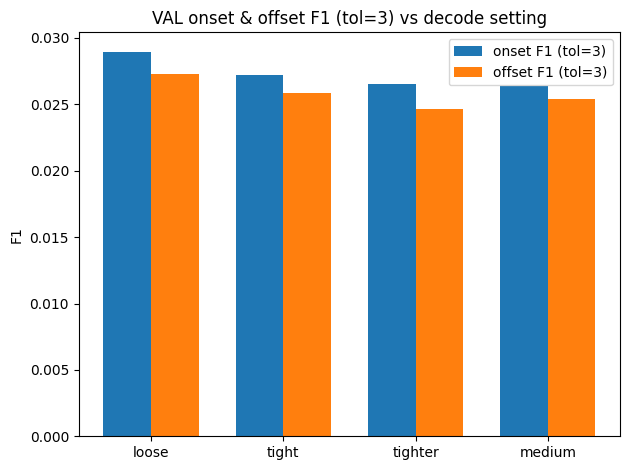

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_val_onset_offset_f1_sweep.png
Best decode: loose {'max_len': 900, 'min_len': 120, 'eos_bias_base': 0.1, 'eos_bias_slope': 0.01, 'hard_force_eos_at': 880, 'max_notes_per_frame': 8, 'max_active_notes': 12, 'note_penalty': 0.0}

FINAL VAL onset/offset: {'onset_P': 0.029608968513649647, 'onset_R': 0.02837171052631433, 'onset_F1': 0.02897713850757162, 'onset_tp': 552, 'onset_fp': 18091, 'onset_fn': 18904, 'offset_P': 0.02798899854392342, 'offset_R': 0.026668722059502253, 'offset_F1': 0.027312914430059277, 'offset_tp': 519, 'offset_fp': 18024, 'offset_fn': 18942}
FINAL TEST onset/offset: {'onset_P': 0.026347305389220428, 'onset_R': 0.023065977682916832, 'onset_F1': 0.024597691969811434, 'onset_tp': 616, 'onset_fp': 22764, 'onset_fn': 26090, 'offset_P': 0.024093275394741466, 'offset_R': 0.020931449502877293, 'offset_F1': 0.02240134408064439, 'offset_tp': 560, 'offset_fp': 22683, 'offset_fn': 26194}
Saved: /home/jovyan/

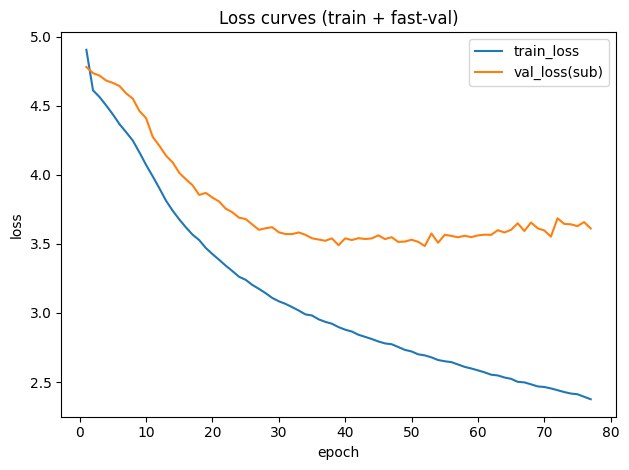

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_curve_loss.png


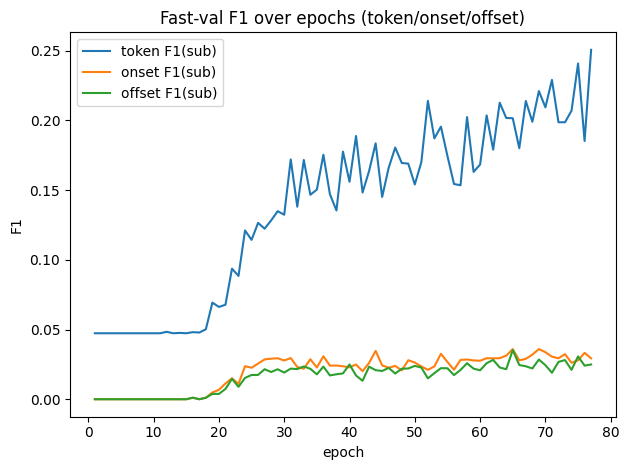

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_curve_f1s.png


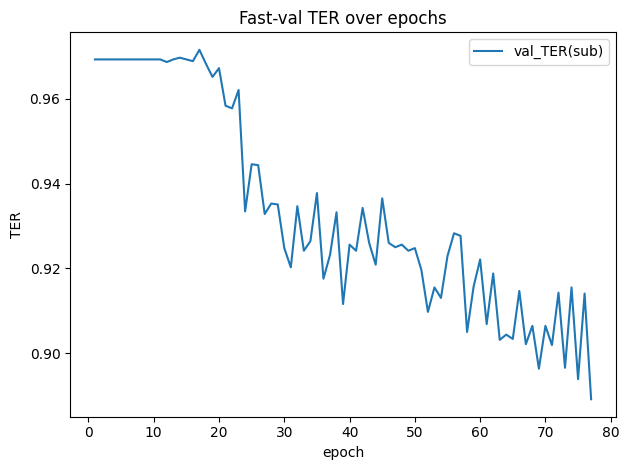

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_curve_ter.png


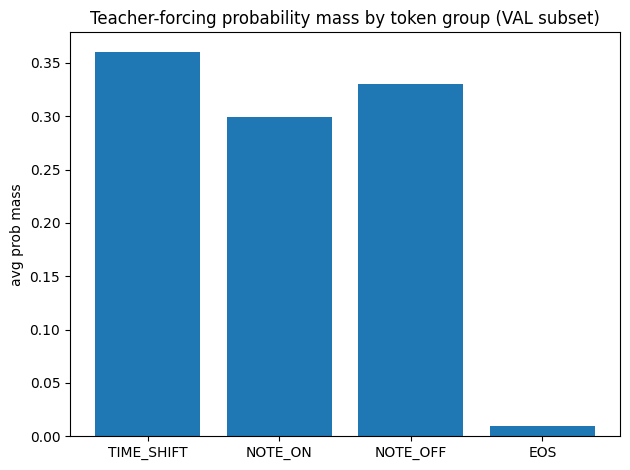

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_tf_mass.png


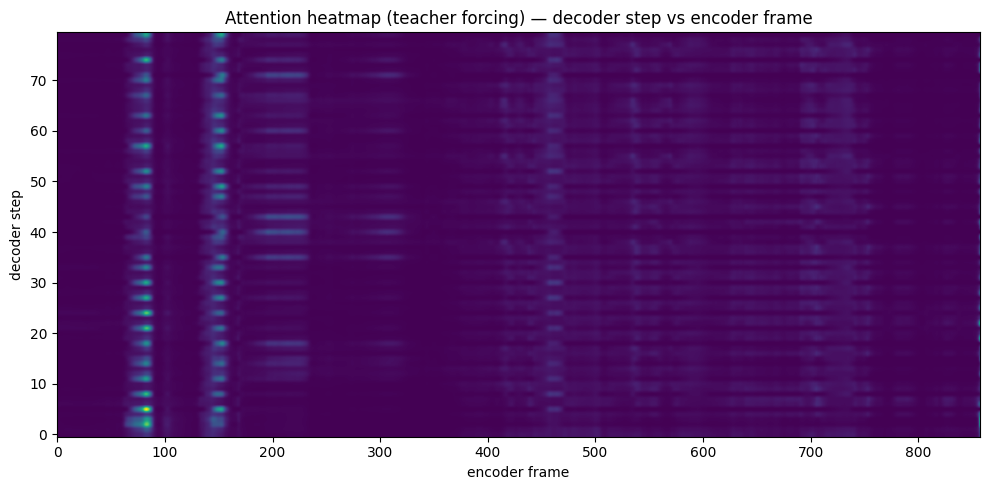

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_attention_heatmap.png


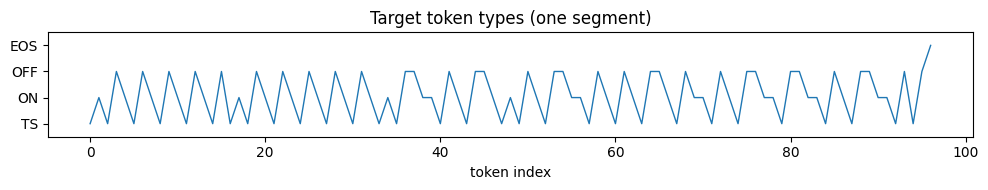

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_tok_types_target.png


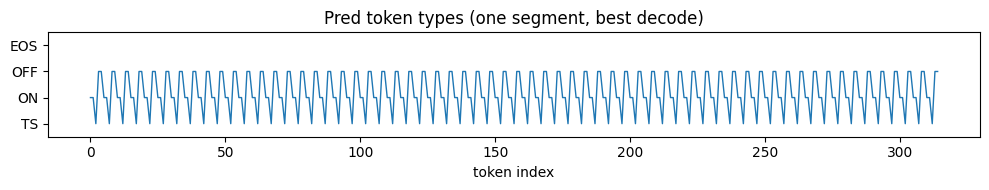

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_tok_types_pred.png

ZIP bundle: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_seq2seq_results.zip
Download via Jupyter file browser from: /home/jovyan/shared/musicnet_event_notebook/figures
Created files:
 - 20260118_173845_attention_heatmap.png
 - 20260118_173845_curve_f1s.png
 - 20260118_173845_curve_loss.png
 - 20260118_173845_curve_ter.png
 - 20260118_173845_final_onset_offset_metrics.json
 - 20260118_173845_seq2seq_results.zip
 - 20260118_173845_tf_mass.png
 - 20260118_173845_tok_types_pred.png
 - 20260118_173845_tok_types_target.png
 - 20260118_173845_val_onset_offset_f1_sweep.png
 - 20260118_173845_val_sweep_onset_offset_tol3.csv


In [ ]:
# ============================================================
# BLOCK 10b (FULL EVAL + ALL VISUALS) — compatible with Block 10 above
# - Loads best checkpoint from best_s2s_path
# - VAL decode sweep (tol=3) using FULL decode (s2s_decode_greedy_full below)
# - Computes onset & offset F1 tolerant on VAL+TEST
# - Saves all result graphics + ZIP
#
# IMPORTANT: This block defines its own FULL decode function and does not
# depend on any old s2s_decode_greedy in the notebook.
# ============================================================

import os, json, zipfile
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

FIG_DIR = Path(FIG_DIR); FIG_DIR.mkdir(parents=True, exist_ok=True)
RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")
print("RUN_TAG:", RUN_TAG)
print("FIG_DIR:", FIG_DIR)

def save_plot(path):
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.show()
    print("Saved:", path)

# -----------------------------
# Load best
# -----------------------------
s2s_model.load_state_dict(torch.load(best_s2s_path, map_location=DEVICE))
s2s_model.to(DEVICE).eval()
print("Loaded checkpoint:", best_s2s_path)

# -----------------------------
# FULL constrained-ish greedy decode (stable, no unpack errors)
# (uses attention that returns (ctx, attn))
# -----------------------------
@torch.no_grad()
def s2s_decode_greedy_full(model, X, x_lens,
                           max_len=900, min_len=120,
                           eos_bias_base=0.1, eos_bias_slope=0.01, hard_force_eos_at=880,
                           max_notes_per_frame=8, max_active_notes=12, note_penalty=0.0):
    """
    Full decode for evaluation. Simple constraints to avoid blow-ups.
    Returns list[list[int]] without EOS token appended.
    """
    model.eval()
    device = X.device
    B = X.size(0)
    enc, enc_mask = model.encode(X, x_lens)

    ys = torch.full((B, 1), SOS_ID, dtype=torch.long, device=device)
    ctx = torch.zeros((B, enc.size(-1)), device=device, dtype=enc.dtype)
    h = None
    finished = torch.zeros(B, dtype=torch.bool, device=device)
    out = [[] for _ in range(B)]

    # pitch state
    active = torch.zeros((B, N_PITCH), dtype=torch.bool, device=device)
    notes_this_frame = torch.zeros(B, dtype=torch.long, device=device)

    for step in range(max_len):
        emb = model.emb(ys[:, -1])
        x_t = torch.cat([emb, ctx], dim=-1).unsqueeze(1)
        o, h = model.lstm(x_t, h)
        h_t = o.squeeze(1)
        ctx, attn = model.attn(h_t, enc, enc_mask)  # ALWAYS 2 outputs now

        logits = model.out(torch.cat([h_t, ctx], dim=-1))

        logits[:, PAD_ID] = -1e9
        logits[:, SOS_ID] = -1e9
        logits[:, CTC_BLANK_ID] = -1e9

        # optional note penalty per frame
        if note_penalty != 0.0:
            logits[:, NOTE_ON_BASE:EVENT_VOCAB] -= notes_this_frame.float().unsqueeze(1) * note_penalty

        # block invalid on/off based on active state
        for p in range(N_PITCH):
            on_id = NOTE_ON_BASE + p
            off_id = NOTE_OFF_BASE + p
            logits[:, off_id] = torch.where(active[:, p], logits[:, off_id], torch.full_like(logits[:, off_id], -1e9))
            logits[:, on_id]  = torch.where(~active[:, p], logits[:, on_id],  torch.full_like(logits[:, on_id],  -1e9))

        # polyphony cap: block NOTE_ON if too many active
        too_poly = active.sum(dim=1) >= max_active_notes
        if too_poly.any():
            logits[too_poly, NOTE_ON_BASE:NOTE_OFF_BASE] = -1e9

        # cap note events per frame (after enough note events, discourage more)
        force_ts = notes_this_frame >= max_notes_per_frame
        if force_ts.any():
            logits[force_ts, NOTE_ON_BASE:EVENT_VOCAB] = -1e9  # forces TS or EOS if allowed

        # EOS control
        if step < min_len:
            logits[:, EOS_ID] = -1e9
        else:
            logits[:, EOS_ID] += (eos_bias_base + eos_bias_slope * (step - min_len))

        if step >= hard_force_eos_at:
            logits[:, EOS_ID] = 1e4

        nxt = logits.argmax(dim=-1)
        ys = torch.cat([ys, nxt.unsqueeze(1)], dim=1)

        for i in range(B):
            if finished[i]:
                continue
            t = int(nxt[i].item())
            if t == EOS_ID:
                finished[i] = True
                continue
            out[i].append(t)

            # update state
            if TIME_SHIFT_BASE <= t < NOTE_ON_BASE:
                notes_this_frame[i] = 0
            elif NOTE_ON_BASE <= t < NOTE_OFF_BASE:
                p = t - NOTE_ON_BASE
                active[i, p] = True
                notes_this_frame[i] += 1
            elif NOTE_OFF_BASE <= t < EVENT_VOCAB:
                p = t - NOTE_OFF_BASE
                active[i, p] = False
                notes_this_frame[i] += 1

        if bool(finished.all()):
            break

    return out

# -----------------------------
# Token -> onset/offset sets + tolerant match (reused)
# -----------------------------
def tokens_to_onsets_offsets(tokens):
    t = 0
    on = set()
    off = set()
    for tok in tokens:
        if tok == PAD_ID or tok == EOS_ID:
            continue
        if TIME_SHIFT_BASE <= tok < NOTE_ON_BASE:
            t += (tok - TIME_SHIFT_BASE) + 1
        elif NOTE_ON_BASE <= tok < NOTE_OFF_BASE:
            on.add((t, tok - NOTE_ON_BASE))
        elif NOTE_OFF_BASE <= tok < EVENT_VOCAB:
            off.add((t, tok - NOTE_OFF_BASE))
    return on, off

def tolerant_match(pred_set, gt_set, tol=3):
    gt_by_pitch = {}
    for f,p in gt_set:
        gt_by_pitch.setdefault(p, []).append(f)
    for p in gt_by_pitch:
        gt_by_pitch[p].sort()
    tp=0
    used=set()
    for f,p in pred_set:
        if p not in gt_by_pitch:
            continue
        for g in gt_by_pitch[p]:
            if (g,p) in used:
                continue
            if abs(g-f) <= tol:
                tp += 1
                used.add((g,p))
                break
    fp=len(pred_set)-tp
    fn=len(gt_set)-tp
    return tp,fp,fn

def prf(tp,fp,fn):
    P=tp/(tp+fp+1e-9)
    R=tp/(tp+fn+1e-9)
    F1=2*tp/(2*tp+fp+fn+1e-9)
    return P,R,F1

@torch.no_grad()
def eval_onset_offset_f1_full(model, loader, decode_kwargs, tol=3):
    model.eval()
    TP_on=FP_on=FN_on=0
    TP_off=FP_off=FN_off=0

    for batch in loader:
        X  = batch["X"].to(DEVICE, non_blocking=True)
        xl = batch["x_lens"].to(DEVICE, non_blocking=True)
        y  = batch["y"]
        yl = batch["y_lens"]

        preds = s2s_decode_greedy_full(model, X, xl, **decode_kwargs)

        for i in range(len(preds)):
            gt_tokens = y[i,:int(yl[i])].tolist()
            gt_on, gt_off = tokens_to_onsets_offsets(gt_tokens)
            pr_on, pr_off = tokens_to_onsets_offsets(preds[i])

            tp,fp,fn = tolerant_match(pr_on, gt_on, tol=tol)
            TP_on += tp; FP_on += fp; FN_on += fn

            tp,fp,fn = tolerant_match(pr_off, gt_off, tol=tol)
            TP_off += tp; FP_off += fp; FN_off += fn

    Pon,Ron,Fon = prf(TP_on,FP_on,FN_on)
    Poff,Roff,Foff = prf(TP_off,FP_off,FN_off)

    return {
        "onset_P": Pon, "onset_R": Ron, "onset_F1": Fon, "onset_tp": TP_on, "onset_fp": FP_on, "onset_fn": FN_on,
        "offset_P": Poff, "offset_R": Roff, "offset_F1": Foff, "offset_tp": TP_off, "offset_fp": FP_off, "offset_fn": FN_off,
    }

# -----------------------------
# VAL decode sweep (your known best candidate set)
# -----------------------------
base = dict(max_len=900, min_len=120, eos_bias_base=0.1, eos_bias_slope=0.01, hard_force_eos_at=880)
cands = [
    dict(setting="loose",   **base, max_notes_per_frame=8, max_active_notes=12, note_penalty=0.00),
    dict(setting="medium",  **base, max_notes_per_frame=6, max_active_notes=8,  note_penalty=0.15),
    dict(setting="tight",   **base, max_notes_per_frame=5, max_active_notes=6,  note_penalty=0.20),
    dict(setting="tighter", **base, max_notes_per_frame=4, max_active_notes=6,  note_penalty=0.25),
]

rows=[]
for cfg in cands:
    dk = {k:v for k,v in cfg.items() if k!="setting"}
    m = eval_onset_offset_f1_full(s2s_model, val_loader, dk, tol=3)
    rows.append({"setting": cfg["setting"], **m, **dk})
    print("VAL", cfg["setting"], "=> onsetF1", round(m["onset_F1"],4), "offsetF1", round(m["offset_F1"],4))

sweep_df = pd.DataFrame(rows).sort_values("onset_F1", ascending=False)
sweep_csv = FIG_DIR / f"{RUN_TAG}_val_sweep_onset_offset_tol3.csv"
sweep_df.to_csv(sweep_csv, index=False)
print("Saved:", sweep_csv)

plt.figure()
x = np.arange(len(sweep_df))
plt.bar(x-0.18, sweep_df["onset_F1"], width=0.36, label="onset F1 (tol=3)")
plt.bar(x+0.18, sweep_df["offset_F1"], width=0.36, label="offset F1 (tol=3)")
plt.xticks(x, sweep_df["setting"])
plt.ylabel("F1")
plt.title("VAL onset & offset F1 (tol=3) vs decode setting")
plt.legend()
save_plot(FIG_DIR / f"{RUN_TAG}_val_onset_offset_f1_sweep.png")

best_row = sweep_df.iloc[0].to_dict()
best_decode = {k: best_row[k] for k in ["max_len","min_len","eos_bias_base","eos_bias_slope","hard_force_eos_at","max_notes_per_frame","max_active_notes","note_penalty"]}
print("Best decode:", best_row["setting"], best_decode)

# Final VAL/TEST onset+offset
val_metrics = eval_onset_offset_f1_full(s2s_model, val_loader, best_decode, tol=3)
test_metrics = eval_onset_offset_f1_full(s2s_model, test_loader, best_decode, tol=3)
print("\nFINAL VAL onset/offset:", val_metrics)
print("FINAL TEST onset/offset:", test_metrics)

metrics_json = FIG_DIR / f"{RUN_TAG}_final_onset_offset_metrics.json"
with open(metrics_json, "w") as f:
    json.dump({"best_decode": best_decode, "val": val_metrics, "test": test_metrics}, f, indent=2)
print("Saved:", metrics_json)

# -----------------------------
# Training curves from history_csv
# -----------------------------
hist = pd.read_csv(history_csv)
ep = hist["epoch"].values

plt.figure()
plt.plot(ep, hist["train_loss"], label="train_loss")
plt.plot(ep, hist["val_loss_sub"], label="val_loss(sub)")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss curves (train + fast-val)")
plt.legend()
save_plot(FIG_DIR / f"{RUN_TAG}_curve_loss.png")

plt.figure()
plt.plot(ep, hist["val_F1_sub"], label="token F1(sub)")
plt.plot(ep, hist["val_onset_F1_sub"], label="onset F1(sub)")
plt.plot(ep, hist["val_offset_F1_sub"], label="offset F1(sub)")
plt.xlabel("epoch"); plt.ylabel("F1")
plt.title("Fast-val F1 over epochs (token/onset/offset)")
plt.legend()
save_plot(FIG_DIR / f"{RUN_TAG}_curve_f1s.png")

plt.figure()
plt.plot(ep, hist["val_TER_sub"], label="val_TER(sub)")
plt.xlabel("epoch"); plt.ylabel("TER")
plt.title("Fast-val TER over epochs")
plt.legend()
save_plot(FIG_DIR / f"{RUN_TAG}_curve_ter.png")

# -----------------------------
# TF token-group mass plot
# -----------------------------
@torch.no_grad()
def tf_mass_by_group(model, loader, num_batches=5):
    model.eval()
    mass_ts=mass_on=mass_off=mass_eos=0.0
    count=0
    ce = nn.CrossEntropyLoss(ignore_index=PAD_ID, weight=CLASS_W)
    for bi, batch in enumerate(loader):
        if bi>=num_batches: break
        X  = batch["X"].to(DEVICE, non_blocking=True)
        xl = batch["x_lens"].to(DEVICE, non_blocking=True)
        y  = batch["y"].to(DEVICE, non_blocking=True)
        yl = batch["y_lens"].to(DEVICE, non_blocking=True)
        y_in, y_out = make_s2s_io_event(y, yl)
        logits = s2s_model.forward_teacher_forcing(X, xl, y_in)
        probs = torch.softmax(logits.float(), dim=-1)
        mask = (y_out != PAD_ID)
        m = mask.sum().item()
        if m==0: continue
        ts = probs[:,:,TIME_SHIFT_BASE:NOTE_ON_BASE].sum(dim=-1)
        on = probs[:,:,NOTE_ON_BASE:NOTE_OFF_BASE].sum(dim=-1)
        off= probs[:,:,NOTE_OFF_BASE:EVENT_VOCAB].sum(dim=-1)
        eos= probs[:,:,EOS_ID]
        mass_ts += float(ts[mask].sum().item()/m)
        mass_on += float(on[mask].sum().item()/m)
        mass_off+= float(off[mask].sum().item()/m)
        mass_eos+= float(eos[mask].sum().item()/m)
        count += 1
    return {"TIME_SHIFT": mass_ts/max(1,count),
            "NOTE_ON": mass_on/max(1,count),
            "NOTE_OFF": mass_off/max(1,count),
            "EOS": mass_eos/max(1,count)}

tfm = tf_mass_by_group(s2s_model, val_loader, num_batches=5)
plt.figure()
plt.bar(list(tfm.keys()), list(tfm.values()))
plt.title("Teacher-forcing probability mass by token group (VAL subset)")
plt.ylabel("avg prob mass")
save_plot(FIG_DIR / f"{RUN_TAG}_tf_mass.png")

# -----------------------------
# Attention heatmap (fast) using returned attn weights
# -----------------------------
@torch.no_grad()
def attention_heatmap_example(model, loader, max_steps=80):
    batch = next(iter(loader))
    X  = batch["X"][:1].to(DEVICE)
    xl = batch["x_lens"][:1].to(DEVICE)
    y  = batch["y"][:1].to(DEVICE)
    yl = batch["y_lens"][:1].to(DEVICE)
    y_in, y_out = make_s2s_io_event(y, yl)

    enc, enc_mask = model.encode(X, xl)
    ctx = torch.zeros((1, enc.size(-1)), device=DEVICE, dtype=enc.dtype)
    h = None
    emb_all = model.emb(y_in)  # (1,L,dec)

    A = []
    L = min(y_in.size(1), max_steps)
    for t in range(L):
        x_t = torch.cat([emb_all[:, t, :], ctx], dim=-1).unsqueeze(1)
        o, h = model.lstm(x_t, h)
        h_t = o.squeeze(1)
        ctx, attn = model.attn(h_t, enc, enc_mask)  # (1,D), (1,T)
        A.append(attn.squeeze(0).detach().cpu().numpy())
    return np.stack(A, axis=0)

A = attention_heatmap_example(s2s_model, val_loader, max_steps=80)
plt.figure(figsize=(10,5))
plt.imshow(A, aspect="auto", origin="lower")
plt.title("Attention heatmap (teacher forcing) — decoder step vs encoder frame")
plt.xlabel("encoder frame"); plt.ylabel("decoder step")
save_plot(FIG_DIR / f"{RUN_TAG}_attention_heatmap.png")

# -----------------------------
# Token-type timelines (target vs predicted)
# -----------------------------
def tok_type(t):
    if TIME_SHIFT_BASE <= t < NOTE_ON_BASE: return 0
    if NOTE_ON_BASE <= t < NOTE_OFF_BASE: return 1
    if NOTE_OFF_BASE <= t < EVENT_VOCAB: return 2
    if t == EOS_ID: return 3
    return 4

def plot_token_types(seq, title, path, max_tokens=400):
    types = [tok_type(t) for t in seq[:max_tokens]]
    plt.figure(figsize=(10,2))
    plt.plot(types, linewidth=1)
    plt.yticks([0,1,2,3], ["TS","ON","OFF","EOS"])
    plt.ylim(-0.5,3.5)
    plt.title(title); plt.xlabel("token index")
    save_plot(path)

batch = next(iter(val_loader))
tgt = batch["y"][0, :batch["y_lens"][0].item()].cpu().numpy().tolist()
pred = s2s_decode_greedy_full(s2s_model, batch["X"][:1].to(DEVICE), batch["x_lens"][:1].to(DEVICE), **best_decode)[0]
plot_token_types(tgt, "Target token types (one segment)", FIG_DIR / f"{RUN_TAG}_tok_types_target.png")
plot_token_types(pred, "Pred token types (one segment, best decode)", FIG_DIR / f"{RUN_TAG}_tok_types_pred.png")

# -----------------------------
# ZIP bundle
# -----------------------------
zip_path = FIG_DIR / f"{RUN_TAG}_seq2seq_results.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in FIG_DIR.glob(f"{RUN_TAG}_*"):
        zf.write(p, arcname=p.name)
    zf.write(Path(history_csv), arcname=Path(history_csv).name)
    zf.write(Path(best_s2s_path), arcname=Path(best_s2s_path).name)

print("\nZIP bundle:", zip_path)
print("Download via Jupyter file browser from:", FIG_DIR)
print("Created files:")
for p in sorted(FIG_DIR.glob(f"{RUN_TAG}_*")):
    print(" -", p.name)


### Attention Diagnostics + Interpretable Confusion Matrices (Teacher Forcing)

This block generates a focused set of **attention visualizations** and **confusion-style diagnostics** that remain interpretable for an event-token Seq2Seq model. Instead of attempting a full token-ID confusion matrix (too large and not meaningful), it summarizes errors at the level of token *types* and (optionally) NOTE_ON *pitch* confusions.

Artifacts saved to `FIG_DIR` (with a timestamped `RUN_TAG` prefix):
1. `attention_heatmap.png`
2. `attention_peak_vs_step.png`
3. `attention_entropy_vs_step.png`
4. `mel_with_attention_peak_overlay.png`
5. `token_types_strip.png`
6. `token_type_confusion_matrix_teacher_forcing.png`
7. `note_on_pitch_confusion_topK.png` (optional but useful)

---

#### Run setup and standardized saving

A run-specific `RUN_TAG` is created and used to prefix all outputs. `savefig(...)` ensures consistent rendering and saving (tight layout, high DPI) and prints the resulting filename.

---

#### Token typing utilities (making analysis interpretable)

Event tokens are mapped into a small set of semantic categories:
- `TIME_SHIFT`
- `NOTE_ON`
- `NOTE_OFF`
- `EOS`
- `OTHER` (fallback)

This abstraction allows confusion analysis and time-aligned plots without needing to reason over thousands of possible token IDs.

A helper `token_pitch(...)` extracts pitch indices for NOTE_ON / NOTE_OFF tokens so pitch-level confusion can be computed in a meaningful subset of events.

---

#### Robust attention extraction (compatible with attention implementations)

`attn_ctx_and_weights(...)` provides a safe interface to obtain `(ctx, attn)` even if the attention module exposes only `ctx`:
- if `model.attn(...)` returns `(ctx, attn)`, it uses that,
- otherwise, if the attention module has parameters `W_h`, `W_s`, and `v`, it reconstructs attention weights by recomputing the energy scores and softmax.

This makes the visualization block portable across slightly different attention implementations.

---

## Part A — Attention matrix + derived plots (single example)

`collect_attention_matrix_teacher_forcing(...)` extracts an attention matrix under **teacher forcing** for a single sample:
- `A`: attention weights with shape `(U, T_enc)` where `U` is the number of decoder steps collected and `T_enc` is the encoder time length,
- `X_mel`: the corresponding log-mel input `(T_mel, M)` for visualization,
- `y_in0`: the teacher-forcing input token sequence, used to plot token types vs step.

Generated plots:

**1) Attention heatmap**
Shows alignment structure: decoder step (y-axis) vs encoder frame (x-axis). Useful for diagnosing whether the model learns monotonic/near-monotonic alignment (typical for transcription) or exhibits diffuse/unstructured attention.

**2) Attention peak location vs step**
Plots `argmax_t A[u,t]` over decoder steps. This indicates whether the model’s attention focus advances through the input over time or jumps erratically.

**3) Attention entropy vs step**
Computes `H(A[u]) = -∑ A[u,t] log A[u,t]` per step. Lower entropy indicates sharper focus; high entropy indicates diffuse attention. This is a compact way to track “confidence” in alignment.

**4) Log-mel with attention peak overlay**
Overlays attention peaks (mapped from encoder frames to mel frames via linear scaling) onto the log-mel spectrogram. This gives an intuitive sense of *where in the audio* the model is attending as it consumes teacher-forcing tokens.

**5) Token-type strip**
Plots the token category (TS / ON / OFF / EOS) at each teacher-forcing step. This provides context for interpreting the attention plots (e.g., whether attention sharpens around NOTE_ON events or time-shifts).

---

## Part B — Token-type confusion matrix (teacher forcing)

`token_type_confusion_teacher_forcing(...)` computes an interpretable confusion matrix over token **types**, not token IDs:
- Ground truth is `y_out` (next-token targets).
- Predictions are `argmax(logits)` under teacher forcing.
- Only non-PAD target positions are counted.

The result is a `5×5` matrix (TS/ON/OFF/EOS/OTHER), normalized row-wise for visualization. This answers: *when the true token is NOTE_ON, does the model tend to predict NOTE_ON, or does it collapse into TIME_SHIFT, etc.?*

This is a sensible and stable diagnostic because it measures classification behavior at positions that are aligned by teacher forcing rather than requiring sequence-level alignment.

---

## Part C — NOTE_ON pitch confusion (top-K pitches, teacher forcing)

`note_on_pitch_confusion_topK(...)` provides a pitch-level confusion heatmap restricted to NOTE_ON positions:
1) It first counts NOTE_ON pitch frequencies in the inspected subset and selects the `topK` most frequent pitches.
2) It then evaluates teacher-forcing predictions **only at steps where the ground truth is NOTE_ON** and counts confusions where the predicted token is also NOTE_ON within the top-K set.

The resulting heatmap (row-normalized) answers: *given that the model is predicting NOTE_ON at the correct “type” positions, which pitches does it confuse most often?*  
This isolates pitch confusions from sequence-structure errors and typically yields a more actionable diagnostic.

---

#### Summary of what this block is diagnosing

- **Alignment behavior** (heatmap / peak / entropy / mel overlay)
- **Structural token-type errors** (TS vs ON vs OFF vs EOS confusions)
- **Pitch confusions conditional on NOTE_ON** (within the most frequent pitch set)

All outputs are saved into `FIG_DIR` with the current `RUN_TAG` prefix for clean run-to-run comparisons.


Saving to: /home/jovyan/shared/musicnet_event_notebook/figures RUN_TAG: 20260118_202258
Attention extracted: (80, 858) seconds: 0.09


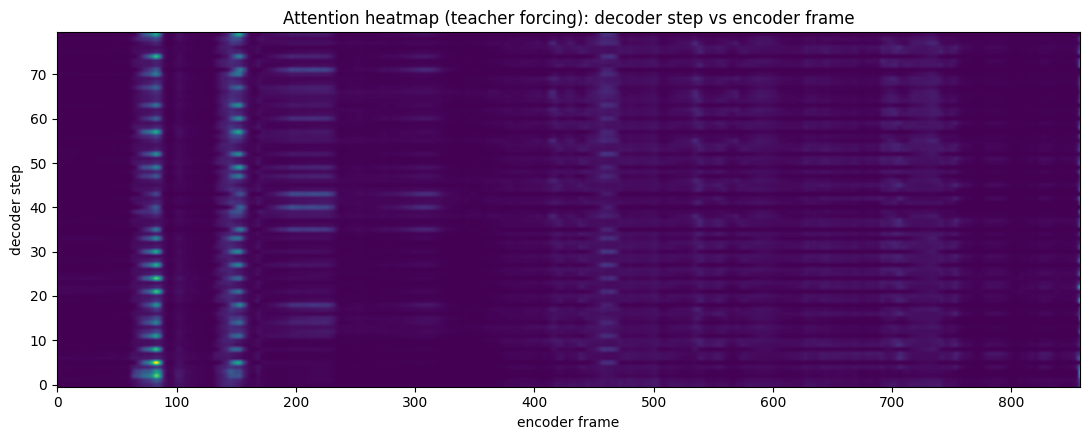

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_202258_attention_heatmap.png


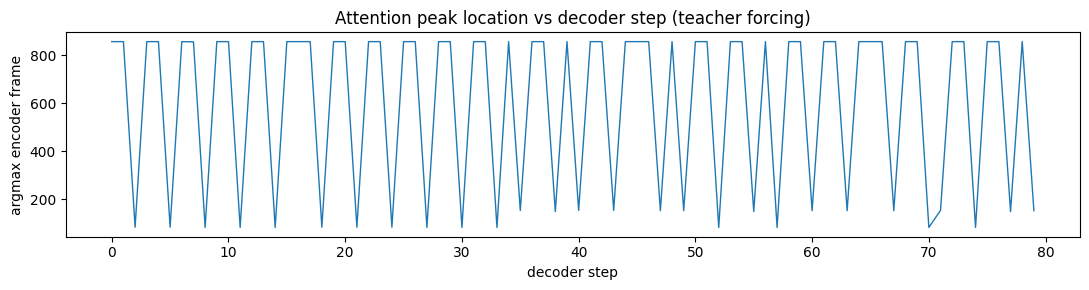

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_202258_attention_peak_vs_step.png


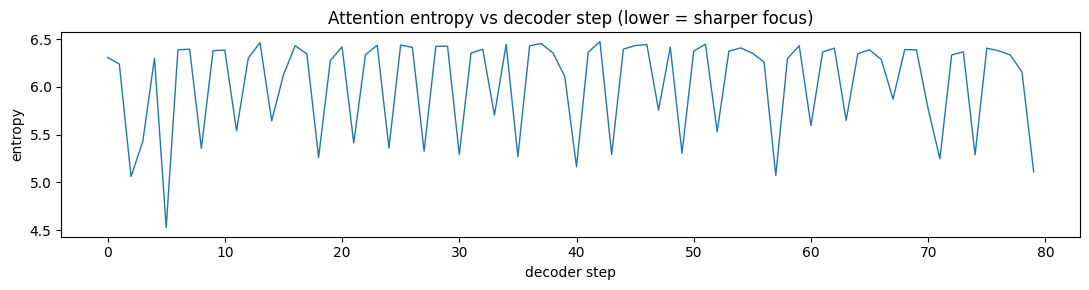

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_202258_attention_entropy_vs_step.png


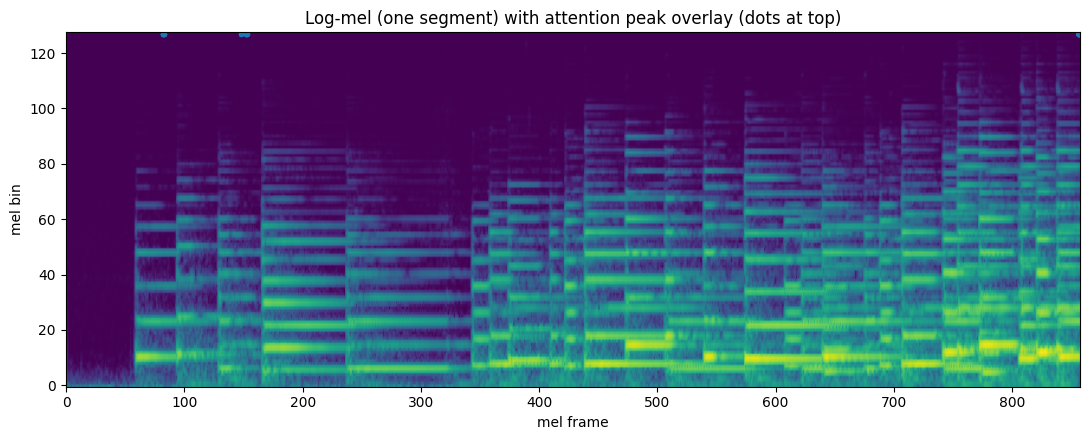

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_202258_mel_with_attention_peak_overlay.png


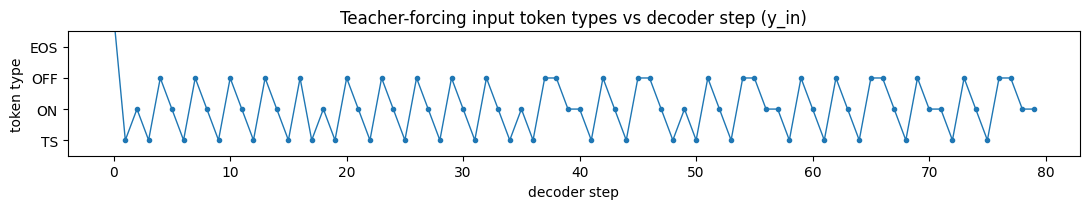

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_202258_token_types_strip.png


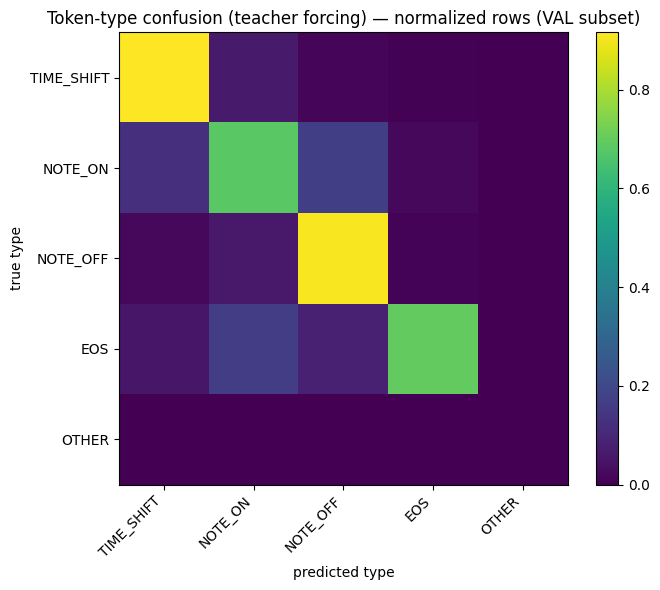

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_202258_token_type_confusion_matrix_teacher_forcing.png


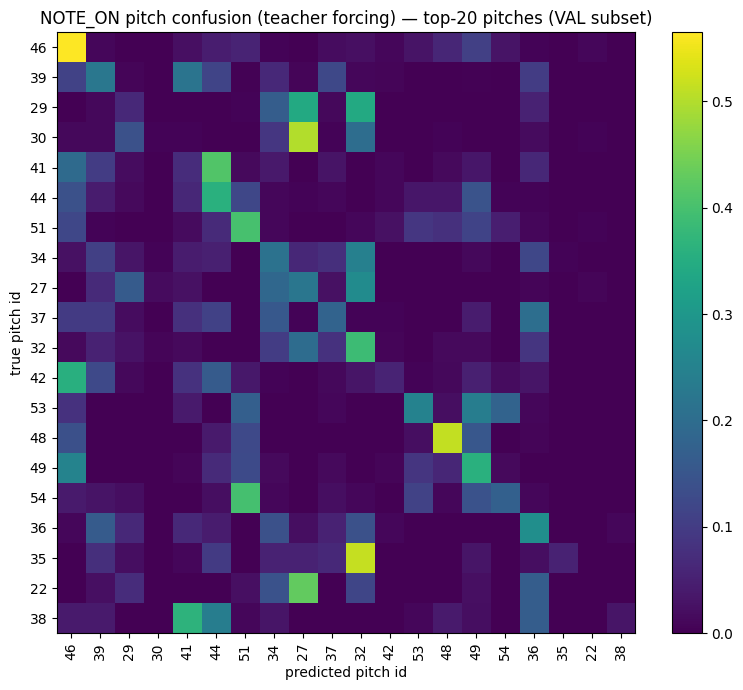

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_202258_note_on_pitch_confusion_topK.png
Done. All attention visuals + confusion matrices saved to FIG_DIR.


In [25]:
# ============================================================
# ATTENTION VISUALS + (SENSIBLE) CONFUSION MATRICES
# Works with your Seq2Seq event-token model.
#
# Produces (saved to FIG_DIR):
# 1) attention_heatmap.png
# 2) attention_peak_vs_step.png
# 3) attention_entropy_vs_step.png
# 4) mel_with_attention_peak_overlay.png
# 5) token_types_strip.png
# 6) token_type_confusion_matrix_teacher_forcing.png   (makes sense)
# 7) note_on_pitch_confusion_topK.png                  (optional but useful)
#
# Assumes you already have:
# - s2s_model (trained), val_loader (or test_loader)
# - make_s2s_io_event (teacher-forcing inputs)
# - CFG.hop_length, CFG.n_mels
# - token constants: TIME_SHIFT_BASE, NOTE_ON_BASE, NOTE_OFF_BASE, EVENT_VOCAB, EOS_ID, PAD_ID
# - N_PITCH, DEVICE, FIG_DIR
#
# Notes:
# - Confusion matrix on full token IDs is too big and not very interpretable.
#   We do confusion on TOKEN TYPES (TS/ON/OFF/EOS) under teacher forcing instead.
# - Pitch confusion is computed for NOTE_ON tokens only, for the most frequent pitches.
# ============================================================

import os, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from collections import Counter, defaultdict

FIG_DIR = Path(globals().get("FIG_DIR", "/home/jovyan/shared/musicnet_event_notebook/figures"))
FIG_DIR.mkdir(parents=True, exist_ok=True)
RUN_TAG = time.strftime("%Y%m%d_%H%M%S")

print("Saving to:", FIG_DIR, "RUN_TAG:", RUN_TAG)

def savefig(name):
    path = FIG_DIR / f"{RUN_TAG}_{name}.png"
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.show()
    print("Saved:", path)

# -----------------------------
# Helpers: token type + token->pitch
# -----------------------------
def token_type_id(tok: int) -> int:
    # 0=TS, 1=ON, 2=OFF, 3=EOS, 4=OTHER
    if TIME_SHIFT_BASE <= tok < NOTE_ON_BASE: return 0
    if NOTE_ON_BASE <= tok < NOTE_OFF_BASE: return 1
    if NOTE_OFF_BASE <= tok < EVENT_VOCAB: return 2
    if tok == EOS_ID: return 3
    return 4

TYPE_NAMES = ["TIME_SHIFT", "NOTE_ON", "NOTE_OFF", "EOS", "OTHER"]

def token_pitch(tok: int):
    if NOTE_ON_BASE <= tok < NOTE_OFF_BASE:
        return ("ON", tok - NOTE_ON_BASE)
    if NOTE_OFF_BASE <= tok < EVENT_VOCAB:
        return ("OFF", tok - NOTE_OFF_BASE)
    return (None, None)

# -----------------------------
# Helper: robust attention call
# Returns ctx, attn (attn may be None if not available)
# -----------------------------
def attn_ctx_and_weights(model, h_t, enc, enc_mask):
    out = model.attn(h_t, enc, enc_mask)
    if isinstance(out, (tuple, list)) and len(out) >= 2:
        return out[0], out[1]
    # If attention returns only ctx, try to compute weights using its parameters (W_h/W_s/v)
    ctx = out
    if all(hasattr(model.attn, a) for a in ["W_h","W_s","v"]):
        h32 = h_t.float()
        e32 = enc.float()
        energy = model.attn.v(torch.tanh(model.attn.W_h(h32).unsqueeze(1) + model.attn.W_s(e32))).squeeze(-1)
        energy = energy.masked_fill(enc_mask, -1e4)
        attn = torch.softmax(energy, dim=-1)
        return ctx, attn
    return ctx, None

# ============================================================
# PART A: ATTENTION MATRIX + DERIVED VISUALS (single example)
# ============================================================

@torch.no_grad()
def collect_attention_matrix_teacher_forcing(model, batch, max_steps=120):
    """
    Collect A: (U, Tenc) attention weights under teacher forcing for ONE sample.
    Also returns mel X (Tmel,M), and token sequence y_in for plotting token types.
    """
    model.eval()
    device = next(model.parameters()).device

    # single sample
    X = batch["X"][:1].to(device, non_blocking=True)          # (1,Tmel,M)
    xl = batch["x_lens"][:1].to(device, non_blocking=True)    # (1,)
    y = batch["y"][:1].to(device, non_blocking=True)
    yl = batch["y_lens"][:1].to(device, non_blocking=True)

    y_in, y_out = make_s2s_io_event(y, yl)  # (1,L)
    y_in = y_in[:, :max_steps]              # limit

    enc, enc_mask = model.encode(X, xl)     # enc: (1,Tenc,D)
    Tenc = enc.size(1)

    ctx = torch.zeros((1, enc.size(-1)), device=device, dtype=enc.dtype)
    h = None
    emb_all = model.emb(y_in)               # (1,L,dec)

    A = []
    for t in range(y_in.size(1)):
        x_t = torch.cat([emb_all[:, t, :], ctx], dim=-1).unsqueeze(1)
        o, h = model.lstm(x_t, h)
        h_t = o.squeeze(1)
        ctx, attn = attn_ctx_and_weights(model, h_t, enc, enc_mask)
        if attn is None:
            break
        A.append(attn.squeeze(0).detach().cpu().numpy())

    if len(A) == 0:
        raise RuntimeError("Could not extract attention weights (attn returned None).")

    A = np.stack(A, axis=0)  # (U,Tenc)
    X_mel = batch["X"][0].cpu().numpy()     # (Tmel,M)
    y_in0 = y_in[0].detach().cpu().numpy().tolist()

    return A, X_mel, y_in0

batch = next(iter(val_loader))
t0 = time.time()
A, X_mel, y_in0 = collect_attention_matrix_teacher_forcing(s2s_model, batch, max_steps=80)
if DEVICE == "cuda":
    torch.cuda.synchronize()
print("Attention extracted:", A.shape, "seconds:", round(time.time()-t0, 2))

# 1) Attention heatmap
plt.figure(figsize=(11,4.5))
plt.imshow(A, aspect="auto", origin="lower")
plt.title("Attention heatmap (teacher forcing): decoder step vs encoder frame")
plt.xlabel("encoder frame")
plt.ylabel("decoder step")
savefig("attention_heatmap")

# 2) Attention peak frame vs step (argmax)
peak = A.argmax(axis=1)
plt.figure(figsize=(11,3.0))
plt.plot(peak, linewidth=1)
plt.title("Attention peak location vs decoder step (teacher forcing)")
plt.xlabel("decoder step")
plt.ylabel("argmax encoder frame")
savefig("attention_peak_vs_step")

# 3) Attention entropy vs step (sharp vs diffuse)
eps = 1e-12
entropy = -(A * np.log(A + eps)).sum(axis=1)
plt.figure(figsize=(11,3.0))
plt.plot(entropy, linewidth=1)
plt.title("Attention entropy vs decoder step (lower = sharper focus)")
plt.xlabel("decoder step")
plt.ylabel("entropy")
savefig("attention_entropy_vs_step")

# 4) Log-mel with attention peak overlay
# X_mel is (Tmel,M). Encoder frames Tenc are usually close to Tmel, but may differ.
# Map encoder frame index -> mel frame index by linear scaling:
Tmel = X_mel.shape[0]
Tenc = A.shape[1]
peak_mel = np.clip((peak * (Tmel-1) / max(1, (Tenc-1))).round().astype(int), 0, Tmel-1)

plt.figure(figsize=(11,4.5))
plt.imshow(X_mel.T, aspect="auto", origin="lower")  # show mel (M x Tmel)
plt.plot(peak_mel, np.full_like(peak_mel, X_mel.shape[1]-1), alpha=0.0)  # noop for autoscale stability
plt.plot(peak_mel, np.full_like(peak_mel, X_mel.shape[1]-1), alpha=0.0)
# overlay as dots at a fixed mel-bin row (top line) just to show time indices
plt.scatter(peak_mel, np.full_like(peak_mel, X_mel.shape[1]-1), s=8)  # points at top
plt.title("Log-mel (one segment) with attention peak overlay (dots at top)")
plt.xlabel("mel frame")
plt.ylabel("mel bin")
savefig("mel_with_attention_peak_overlay")

# 5) Token type strip aligned to steps (from y_in0)
tok_types = [token_type_id(t) for t in y_in0[:len(peak)]]
plt.figure(figsize=(11,2.2))
plt.plot(tok_types, marker="o", linewidth=1, markersize=3)
plt.yticks([0,1,2,3], ["TS","ON","OFF","EOS"])
plt.ylim(-0.5,3.5)
plt.title("Teacher-forcing input token types vs decoder step (y_in)")
plt.xlabel("decoder step")
plt.ylabel("token type")
savefig("token_types_strip")

# ============================================================
# PART B: CONFUSION MATRIX (token types) under teacher forcing
# This *does* make sense: what token type does the model predict at each step?
# ============================================================

@torch.no_grad()
def token_type_confusion_teacher_forcing(model, loader, max_batches=10, max_steps=200):
    """
    Confusion over token TYPES (TS/ON/OFF/EOS/OTHER) under teacher forcing:
    compares argmax(logits) vs ground-truth y_out at each step.
    """
    model.eval()
    K = 5
    cm = np.zeros((K, K), dtype=np.int64)

    for bi, batch in enumerate(loader):
        if bi >= max_batches:
            break
        X  = batch["X"].to(DEVICE, non_blocking=True)
        xl = batch["x_lens"].to(DEVICE, non_blocking=True)
        y  = batch["y"].to(DEVICE, non_blocking=True)
        yl = batch["y_lens"].to(DEVICE, non_blocking=True)

        y_in, y_out = make_s2s_io_event(y, yl)
        y_in = y_in[:, :max_steps]
        y_out = y_out[:, :max_steps]

        logits = model.forward_teacher_forcing(X, xl, y_in)  # (B,L,V)
        pred = logits.argmax(dim=-1)                         # (B,L)

        # consider only non-PAD targets
        mask = (y_out != PAD_ID)

        for i in range(y_out.size(0)):
            valid_idx = mask[i].nonzero(as_tuple=False).squeeze(-1).tolist()
            for t in valid_idx:
                gt_tok = int(y_out[i, t].item())
                pr_tok = int(pred[i, t].item())
                gt_ty = token_type_id(gt_tok)
                pr_ty = token_type_id(pr_tok)
                cm[gt_ty, pr_ty] += 1

    return cm

cm = token_type_confusion_teacher_forcing(s2s_model, val_loader, max_batches=10, max_steps=200)

# Normalize by row for plot
row_sums = cm.sum(axis=1, keepdims=True).clip(min=1)
cm_norm = cm / row_sums

plt.figure(figsize=(7,6))
plt.imshow(cm_norm, origin="upper", aspect="auto")
plt.xticks(range(5), TYPE_NAMES, rotation=45, ha="right")
plt.yticks(range(5), TYPE_NAMES)
plt.title("Token-type confusion (teacher forcing) — normalized rows (VAL subset)")
plt.xlabel("predicted type")
plt.ylabel("true type")
plt.colorbar()
savefig("token_type_confusion_matrix_teacher_forcing")

# ============================================================
# PART C: Pitch confusion (NOTE_ON only), top-K pitches
# This can be useful: "when we predict NOTE_ON, which pitch do we confuse it with?"
# We compute confusion using teacher-forcing argmax, restricted to steps where GT is NOTE_ON.
# ============================================================

@torch.no_grad()
def note_on_pitch_confusion_topK(model, loader, max_batches=10, max_steps=300, topK=20):
    model.eval()
    counts = Counter()

    # First pass: gather GT NOTE_ON pitch frequencies
    gt_pitches = []
    for bi, batch in enumerate(loader):
        if bi >= max_batches:
            break
        y = batch["y"]
        yl = batch["y_lens"]
        for i in range(y.size(0)):
            seq = y[i, :int(yl[i])].tolist()
            for tok in seq:
                kind, p = token_pitch(tok)
                if kind == "ON":
                    counts[p] += 1

    top = [p for p,_ in counts.most_common(topK)]
    if len(top) == 0:
        raise RuntimeError("No NOTE_ON tokens found in the inspected batches.")
    idx = {p:i for i,p in enumerate(top)}
    mat = np.zeros((len(top), len(top)), dtype=np.int64)

    # Second pass: teacher-forcing predictions at GT NOTE_ON positions
    for bi, batch in enumerate(loader):
        if bi >= max_batches:
            break
        X  = batch["X"].to(DEVICE, non_blocking=True)
        xl = batch["x_lens"].to(DEVICE, non_blocking=True)
        y  = batch["y"].to(DEVICE, non_blocking=True)
        yl = batch["y_lens"].to(DEVICE, non_blocking=True)

        y_in, y_out = make_s2s_io_event(y, yl)
        y_in = y_in[:, :max_steps]
        y_out = y_out[:, :max_steps]

        logits = model.forward_teacher_forcing(X, xl, y_in)
        pred = logits.argmax(dim=-1)

        for i in range(y_out.size(0)):
            for t in range(y_out.size(1)):
                gt_tok = int(y_out[i,t].item())
                if gt_tok == PAD_ID:
                    continue
                kind, p_gt = token_pitch(gt_tok)
                if kind != "ON":
                    continue
                if p_gt not in idx:
                    continue
                pr_tok = int(pred[i,t].item())
                kind2, p_pr = token_pitch(pr_tok)
                # only count if prediction is also NOTE_ON and in top set
                if kind2 == "ON" and p_pr in idx:
                    mat[idx[p_gt], idx[p_pr]] += 1

    # Normalize rows for heatmap
    rs = mat.sum(axis=1, keepdims=True).clip(min=1)
    mat_norm = mat / rs
    return top, mat_norm, mat

top_pitches, mat_norm, mat_counts = note_on_pitch_confusion_topK(s2s_model, val_loader, max_batches=10, max_steps=300, topK=20)

plt.figure(figsize=(8,7))
plt.imshow(mat_norm, origin="upper", aspect="auto")
plt.xticks(range(len(top_pitches)), top_pitches, rotation=90)
plt.yticks(range(len(top_pitches)), top_pitches)
plt.title("NOTE_ON pitch confusion (teacher forcing) — top-20 pitches (VAL subset)")
plt.xlabel("predicted pitch id")
plt.ylabel("true pitch id")
plt.colorbar()
savefig("note_on_pitch_confusion_topK")

print("Done. All attention visuals + confusion matrices saved to FIG_DIR.")


### Attention Peak Visuals (Color-Coded by Token Type)

This block produces two primary figures (plus an optional third) that are designed to be directly usable in slides. It overlays the model’s **attention peak locations** and explicitly color-codes them by **event token type**, making it easy to interpret *what kind of decoding decision* (time-shift vs note-on vs note-off vs EOS) the model is attending for at each step.

Saved outputs (run-tagged) in `FIG_DIR`:
- `mel_attention_peaks_colored.png`
- `attention_peak_vs_step_colored.png`
- `attention_entropy_vs_step_colored.png` (optional; only if attention matrix is available)

---

#### Core idea: attention “argmax” as a compact alignment signal

For each decoder step under **teacher forcing**, the attention distribution over encoder frames is computed and reduced to a single scalar:
- `peak_enc = argmax(attn)`.

This peak represents the encoder frame receiving the highest attention weight at that step. While it discards distributional shape information, it is highly effective for presentation: it converts attention into a clean sequence of alignment points.

Because encoder and mel time grids may differ, peaks are mapped to mel-frame indices via linear scaling:
- `peak_mel = round(peak_enc * (Tmel-1) / (Tenc-1))`.

---

#### Token type assignment (semantic decoding context)

Each teacher-forcing input token `y_in[t]` is mapped to a coarse token type:
- TIME_SHIFT
- NOTE_ON
- NOTE_OFF
- EOS
- OTHER

This makes the attention peak plots interpretable: the same alignment signal is shown, but now annotated by the *kind of symbol* the decoder is consuming at that step.

---

#### Robust attention extraction

`attn_ctx_and_weights(...)` ensures compatibility with different attention implementations:
- if the attention module returns `(ctx, attn)`, the weights are used directly,
- otherwise, if the module exposes `W_h`, `W_s`, and `v`, attention weights are reconstructed by recomputing energy scores + masked softmax.

This allows the visualization code to work even if the attention forward method changes slightly across notebook iterations.

---

## Figure 1 — Log-mel + colored attention peak overlay

**What it shows**
- The input log-mel spectrogram for one segment.
- A sequence of dots at the top row whose x-positions correspond to the attention peak time.
- Dot colors indicate the token type (TIME_SHIFT / NOTE_ON / NOTE_OFF / EOS / OTHER).

**Why it is useful**
This figure links decoding behavior to the acoustic input in an intuitive way. It makes it visually clear whether the model tends to:
- attend broadly and continuously during TIME_SHIFT tokens,
- lock onto salient acoustic frames when generating NOTE_ON events,
- behave differently for NOTE_OFF events (often less acoustically localized).

---

## Figure 2 — Peak location vs decoder step (colored by token type)

**What it shows**
- Decoder step on the x-axis.
- Peak mel-frame position on the y-axis.
- Points colored by token type.

**Why it is useful**
This plot exposes whether attention alignment evolves sensibly:
- a generally increasing peak location indicates roughly monotonic progression through the audio segment,
- large oscillations suggest unstable alignment,
- token-type coloring highlights whether NOTE_ON/OFF events concentrate around specific regions or occur uniformly.

---

## Optional Figure 3 — Attention entropy vs step (colored by token type)

If the full attention matrix `A` is available, the block computes per-step entropy:
- `H_t = -∑ attn_t log(attn_t)`.

**Interpretation**
- Lower entropy: sharper attention (more concentrated focus).
- Higher entropy: diffuse attention (uncertain alignment).

Color-coding by token type is particularly informative here: it can reveal, for example, whether NOTE_ON decisions tend to correspond to sharper (lower entropy) attention than TIME_SHIFT steps.

---

#### Output organization

All images are saved to `FIG_DIR` with a timestamp prefix (`RUN_TAG_...png`) to ensure non-overwriting and easy comparison across model checkpoints and runs.


Points: 120 | Tmel: 858 | M: 128


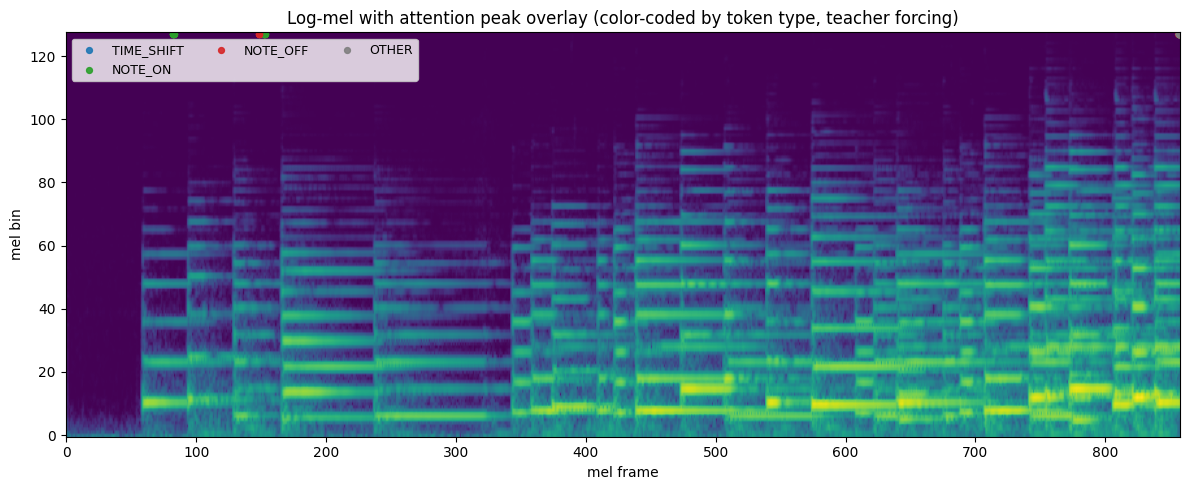

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_205734_mel_attention_peaks_colored.png


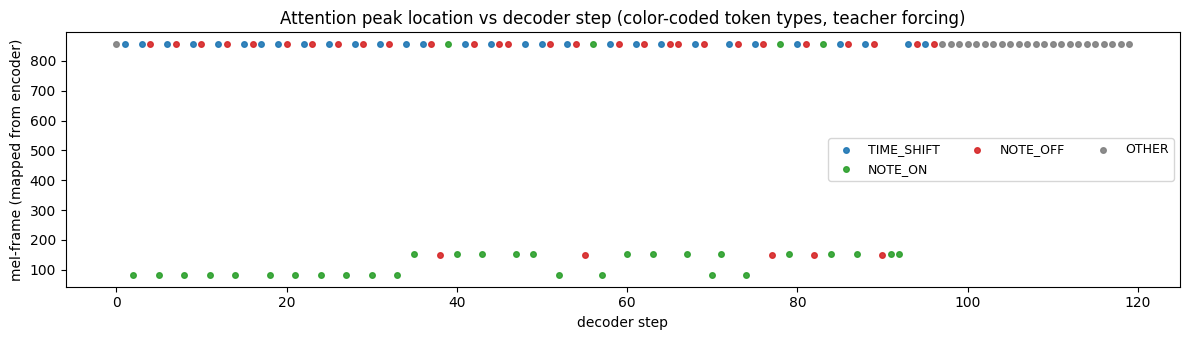

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_205734_attention_peak_vs_step_colored.png


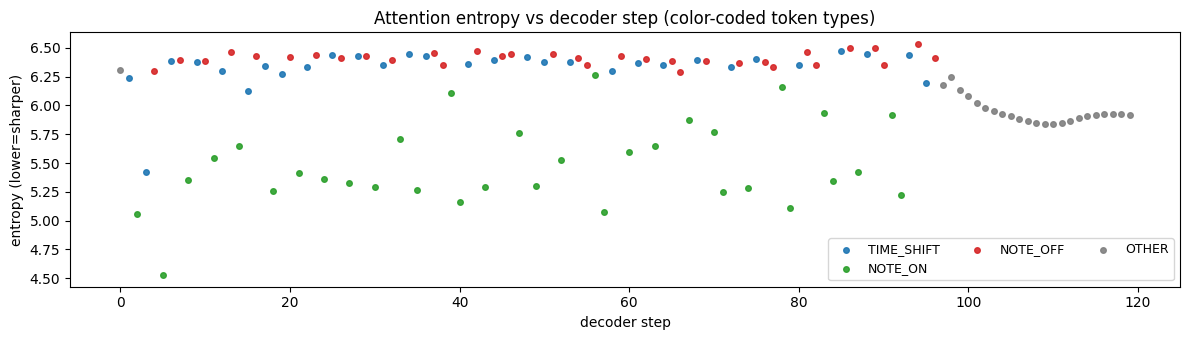

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_205734_attention_entropy_vs_step_colored.png


In [26]:
# ============================================================
# COLOR-CODED ATTENTION PEAKS BY TOKEN TYPE (presentation-ready)
# - Overlays attention peak positions on log-mel, color-coded by token type
# - Also saves a "peak vs step" plot color-coded by token type
#
# Assumes you already have:
# - s2s_model, val_loader
# - make_s2s_io_event
# - token constants: TIME_SHIFT_BASE, NOTE_ON_BASE, NOTE_OFF_BASE, EVENT_VOCAB, EOS_ID, PAD_ID
# - DEVICE, FIG_DIR
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import torch

FIG_DIR = Path(globals().get("FIG_DIR", "/home/jovyan/shared/musicnet_event_notebook/figures"))
FIG_DIR.mkdir(parents=True, exist_ok=True)
RUN_TAG = time.strftime("%Y%m%d_%H%M%S")

def savefig(name):
    path = FIG_DIR / f"{RUN_TAG}_{name}.png"
    plt.tight_layout()
    plt.savefig(path, dpi=220)
    plt.show()
    print("Saved:", path)

# --- token type helper ---
def tok_type_id(tok: int) -> int:
    if TIME_SHIFT_BASE <= tok < NOTE_ON_BASE: return 0
    if NOTE_ON_BASE <= tok < NOTE_OFF_BASE: return 1
    if NOTE_OFF_BASE <= tok < EVENT_VOCAB: return 2
    if tok == EOS_ID: return 3
    return 4

TYPE_NAMES = ["TIME_SHIFT", "NOTE_ON", "NOTE_OFF", "EOS", "OTHER"]

@torch.no_grad()
def attn_ctx_and_weights(model, h_t, enc, enc_mask):
    out = model.attn(h_t, enc, enc_mask)
    if isinstance(out, (tuple, list)) and len(out) >= 2:
        return out[0], out[1]
    # fallback: compute weights if parameters exist
    ctx = out
    if all(hasattr(model.attn, a) for a in ["W_h","W_s","v"]):
        h32 = h_t.float()
        e32 = enc.float()
        energy = model.attn.v(torch.tanh(model.attn.W_h(h32).unsqueeze(1) + model.attn.W_s(e32))).squeeze(-1)
        energy = energy.masked_fill(enc_mask, -1e4)
        attn = torch.softmax(energy, dim=-1)
        return ctx, attn
    return ctx, None

@torch.no_grad()
def collect_attention_peaks_with_types(model, batch, max_steps=120):
    """
    Returns:
      X_mel: (Tmel,M) numpy
      peak_mel: (U,) int mel-frame index of attention argmax
      types: (U,) token-type id for y_in step
      y_in_tokens: list[int]
      A: (U,Tenc) attention matrix (optional, for debug)
    """
    model.eval()
    device = next(model.parameters()).device

    X = batch["X"][:1].to(device, non_blocking=True)       # (1,Tmel,M)
    xl = batch["x_lens"][:1].to(device, non_blocking=True)
    y  = batch["y"][:1].to(device, non_blocking=True)
    yl = batch["y_lens"][:1].to(device, non_blocking=True)

    y_in, y_out = make_s2s_io_event(y, yl)
    y_in = y_in[:, :max_steps]  # (1,U)
    y_in_tokens = y_in[0].detach().cpu().numpy().tolist()

    enc, enc_mask = model.encode(X, xl)                   # (1,Tenc,D)
    Tenc = enc.size(1)
    Tmel = int(batch["X"][0].shape[0])

    ctx = torch.zeros((1, enc.size(-1)), device=device, dtype=enc.dtype)
    h = None
    emb_all = model.emb(y_in)                             # (1,U,dec)

    peaks = []
    types = []
    A_rows = []

    for t in range(y_in.size(1)):
        x_t = torch.cat([emb_all[:, t, :], ctx], dim=-1).unsqueeze(1)
        o, h = model.lstm(x_t, h)
        h_t = o.squeeze(1)

        ctx, attn = attn_ctx_and_weights(model, h_t, enc, enc_mask)
        if attn is None:
            break

        a = attn.squeeze(0).detach().cpu().numpy()        # (Tenc,)
        A_rows.append(a)
        peak_enc = int(a.argmax())
        peaks.append(peak_enc)

        tok = y_in_tokens[t]
        types.append(tok_type_id(tok))

    peaks = np.array(peaks, dtype=int)
    types = np.array(types, dtype=int)

    # map encoder frame -> mel frame by linear scaling
    peak_mel = np.clip((peaks * (Tmel - 1) / max(1, (Tenc - 1))).round().astype(int), 0, Tmel - 1)

    X_mel = batch["X"][0].cpu().numpy()                  # (Tmel,M)
    A = np.stack(A_rows, axis=0) if len(A_rows) else None

    return X_mel, peak_mel, types, y_in_tokens[:len(types)], A

# --- collect from one val batch ---
batch = next(iter(val_loader))
X_mel, peak_mel, types, y_in_tokens, A = collect_attention_peaks_with_types(s2s_model, batch, max_steps=120)

print("Points:", len(peak_mel), "| Tmel:", X_mel.shape[0], "| M:", X_mel.shape[1])

# --- color palette (fixed, readable) ---
# TS: blue, ON: green, OFF: red, EOS: black, OTHER: gray
colors = {0: "tab:blue", 1: "tab:green", 2: "tab:red", 3: "black", 4: "gray"}

# ============================================================
# FIGURE 1: log-mel + colored attention peaks
# ============================================================
plt.figure(figsize=(12,5))
plt.imshow(X_mel.T, aspect="auto", origin="lower")  # mel bins x time
# scatter at top row (M-1)
y_top = np.full_like(peak_mel, X_mel.shape[1]-1)
for k in [0,1,2,3,4]:
    idx = np.where(types == k)[0]
    if len(idx) == 0:
        continue
    plt.scatter(peak_mel[idx], y_top[idx], s=18, c=colors[k], label=TYPE_NAMES[k], alpha=0.9)

plt.title("Log-mel with attention peak overlay (color-coded by token type, teacher forcing)")
plt.xlabel("mel frame")
plt.ylabel("mel bin")
plt.legend(loc="upper left", ncol=3, fontsize=9, frameon=True)
savefig("mel_attention_peaks_colored")

# ============================================================
# FIGURE 2: attention peak frame vs decoder step, colored by token type
# ============================================================
plt.figure(figsize=(12,3.5))
steps = np.arange(len(peak_mel))
for k in [0,1,2,3,4]:
    idx = np.where(types == k)[0]
    if len(idx) == 0:
        continue
    plt.scatter(steps[idx], peak_mel[idx], s=16, c=colors[k], label=TYPE_NAMES[k], alpha=0.9)

plt.title("Attention peak location vs decoder step (color-coded token types, teacher forcing)")
plt.xlabel("decoder step")
plt.ylabel("mel-frame (mapped from encoder)")
plt.legend(loc="best", ncol=3, fontsize=9, frameon=True)
savefig("attention_peak_vs_step_colored")

# ============================================================
# (Optional) FIGURE 3: attention entropy vs step, colored by token type
# ============================================================
if A is not None:
    eps = 1e-12
    entropy = -(A * np.log(A + eps)).sum(axis=1)
    plt.figure(figsize=(12,3.5))
    for k in [0,1,2,3,4]:
        idx = np.where(types == k)[0]
        if len(idx) == 0:
            continue
        plt.scatter(steps[idx], entropy[idx], s=16, c=colors[k], label=TYPE_NAMES[k], alpha=0.9)
    plt.title("Attention entropy vs decoder step (color-coded token types)")
    plt.xlabel("decoder step")
    plt.ylabel("entropy (lower=sharper)")
    plt.legend(loc="best", ncol=3, fontsize=9, frameon=True)
    savefig("attention_entropy_vs_step_colored")
else:
    print("Attention matrix A not available -> skipped entropy plot.")
